In [1]:
!pip install -q tensorflow dmba scikeras graphviz pydot

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import arange
from pandas import set_option
from pandas.plotting import scatter_matrix

2025-10-18 20:09:19.355517: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 20:09:19.385525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn import impute
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Input, Dense, Dropout

In [4]:
%matplotlib inline

In [5]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## Data Preprocessing

In [6]:
data = pd.read_csv("../Data/USCensusTraining.csv", sep=',', header=0)

In [7]:
data.head(10)

,age,workclass,demogweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K.
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K.
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K.
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K.
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K.
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K.
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K.
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K.
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K.
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K.


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   demogweight     25000 non-null  int64 
 3   education       25000 non-null  object
 4   education-num   25000 non-null  int64 
 5   marital-status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital-gain    25000 non-null  int64 
 11  capital-loss    25000 non-null  int64 
 12  hours-per-week  25000 non-null  int64 
 13  native-country  25000 non-null  object
 14  income          25000 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.9+ MB


**We drop `education` column because it is duplicate with `education-num` column, same information**

In [9]:
df = data.drop(columns=['education'])

In [10]:
categorical = ["workclass", "marital-status", "occupation", 
               "relationship", "race", "sex", "native-country"]
numerical = ["age", "demogweight", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

In [11]:
print(df["relationship"].value_counts())

print(df["marital-status"].value_counts())

relationship
Husband           10064
Not-in-family      6443
Own-child          3911
Unmarried          2640
Wife               1213
Other-relative      729
Name: count, dtype: int64
marital-status
Married-civ-spouse       11441
Never-married             8225
Divorced                  3435
Separated                  786
Widowed                    769
Married-spouse-absent      328
Married-AF-spouse           16
Name: count, dtype: int64


In [12]:
df.describe()

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week
count,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000
mean,38.606920,1.897418e+05,10.081440,1088.579040,86.49992,40.407440
std,13.687769,1.052947e+05,2.557035,7486.621197,401.25358,12.299267
min,17.000000,1.228500e+04,1.000000,0.000000,0.00000,1.000000
25%,28.000000,1.179630e+05,9.000000,0.000000,0.00000,40.000000
50%,37.000000,1.783530e+05,10.000000,0.000000,0.00000,40.000000
75%,48.000000,2.368610e+05,12.000000,0.000000,0.00000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.00000,99.000000


**`desctibe()` function only shows info of numeric columns, we can see capital-gain and capital-loss has first 3 qunatiles all equal to 0, ==> something we need to do here**

In [13]:
df['income'].value_counts()

income
<=50K.    19016
>50K.      5984
Name: count, dtype: int64

**We can see the data is not quite balanced, 19016 observations have income $\le$50K, but only 5984 observation has income >50K, ==> should stratify on y when split data**

**We also turn the response variable `income` into a inary variable represented by 1 and 0 for >50K and <=50K**

In [14]:
df['income'] = df['income'].replace({'>50K.': 1, '<=50K.': 0})

/tmp/ipykernel_4127/2949542690.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income'] = df['income'].replace({'>50K.': 1, '<=50K.': 0})


In [15]:
df.head(10)

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


In [16]:
df['workclass'].value_counts()

workclass
Private             17385
Self-emp-not-inc     1978
Local-gov            1624
?                    1399
State-gov             993
Self-emp-inc          857
Federal-gov           750
Without-pay             9
Never-worked            5
Name: count, dtype: int64

In [17]:
df[data.workclass == "?"]

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
69,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,0
77,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,0
106,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24894,62,?,141218,14,Married-civ-spouse,?,Husband,White,Male,0,0,30,United-States,1
24902,61,?,202106,9,Married-civ-spouse,?,Husband,White,Male,0,1902,40,United-States,1
24913,19,?,199495,10,Never-married,?,Own-child,White,Male,0,0,60,United-States,0
24949,36,?,187983,9,Never-married,?,Unmarried,White,Female,0,0,40,United-States,0


In [18]:
df['occupation'].value_counts()

occupation
Prof-specialty       3180
Craft-repair         3122
Exec-managerial      3084
Adm-clerical         2975
Sales                2815
Other-service        2555
Machine-op-inspct    1536
?                    1404
Transport-moving     1228
Handlers-cleaners    1000
Farming-fishing       767
Tech-support          703
Protective-serv       503
Priv-house-serv       121
Armed-Forces            7
Name: count, dtype: int64

In [19]:
df[data.occupation == "?"]

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
69,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,0
77,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,0
106,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24894,62,?,141218,14,Married-civ-spouse,?,Husband,White,Male,0,0,30,United-States,1
24902,61,?,202106,9,Married-civ-spouse,?,Husband,White,Male,0,1902,40,United-States,1
24913,19,?,199495,10,Never-married,?,Own-child,White,Male,0,0,60,United-States,0
24949,36,?,187983,9,Never-married,?,Unmarried,White,Female,0,0,40,United-States,0


In [20]:
df['native-country'].value_counts()

native-country
United-States                 22421
Mexico                          488
?                               445
Philippines                     151
Germany                         102
Canada                           99
Puerto-Rico                      96
El-Salvador                      72
Cuba                             72
England                          72
India                            67
South                            64
China                            60
Jamaica                          58
Italy                            55
Dominican-Republic               54
Vietnam                          50
Guatemala                        50
Poland                           49
Japan                            48
Columbia                         45
Taiwan                           42
Haiti                            38
Iran                             35
Portugal                         28
Nicaragua                        25
Peru                             23
Greece       

In [21]:
df[data["native-country"] == "?"]

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,1
38,31,Private,84154,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,1
51,18,Private,226956,9,Never-married,Other-service,Own-child,White,Female,0,0,30,?,0
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
93,30,Private,117747,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24890,32,Private,39223,6,Separated,Craft-repair,Unmarried,Black,Female,0,0,40,?,0
24891,55,State-gov,117357,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,70,?,1
24923,68,Private,208478,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,18,?,0
24960,20,Private,107242,9,Never-married,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,?,0


In [22]:
X = df.iloc[:, :13]
y = df.iloc[:, -1]

In [23]:
X

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,41,Private,112507,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States
24996,19,Private,236940,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,United-States
24997,33,Private,278514,9,Divorced,Craft-repair,Own-child,White,Female,0,0,42,United-States
24998,21,?,433330,10,Never-married,?,Unmarried,White,Male,0,0,40,United-States


In [24]:
y

0        0
1        0
2        0
3        0
4        0
        ..
24995    0
24996    0
24997    0
24998    0
24999    0
Name: income, Length: 25000, dtype: int64

In [25]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [26]:
# split the training data into train validate sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# fit preprocessor, transform to dense arrays
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)

X_train_enc = X_train_enc.toarray()
X_val_enc = X_val_enc.toarray()

In [27]:
pd.DataFrame(X_train_enc).describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,0.295970,0.120420,0.605687,0.011198,0.019853,0.402033,0.056200,0.029700,0.065000,0.000200,...,0.001250,0.00390,0.000300,0.002800,0.001700,0.000450,0.000500,0.897550,0.002050,0.00025
std,0.188087,0.071273,0.170541,0.076934,0.092485,0.125327,0.230313,0.169763,0.246532,0.014141,...,0.035334,0.06233,0.017318,0.052842,0.041197,0.021209,0.022356,0.303247,0.045232,0.01581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.150685,0.071867,0.533333,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,0.273973,0.112807,0.600000,0.000000,0.000000,0.397959,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
75%,0.424658,0.152282,0.733333,0.000000,0.000000,0.448980,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Part One

### a. 
### Generate a neural network to predict income using the other attributes. You may need to ignore one of the attributes. Describe the topology of the resulting network and draw a detailed picture of the network topology, labeling the input and output layers.

In [28]:
model = Sequential([
    Input(shape=(X_train_enc.shape[1],), name='input'),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform', name='hidden_layer1'),
    Dense(1, activation='sigmoid', name='output')
], name='ANN')

model.compile(
    optimizer=RMSprop(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
history = model.fit(X_train_enc, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=2)

Epoch 1/40
1000/1000 - 1s - 1ms/step - accuracy: 0.8094 - loss: 0.3987 - val_accuracy: 0.8292 - val_loss: 0.3642
Epoch 2/40
1000/1000 - 1s - 934us/step - accuracy: 0.8371 - loss: 0.3517 - val_accuracy: 0.8347 - val_loss: 0.3530
Epoch 3/40
1000/1000 - 1s - 917us/step - accuracy: 0.8416 - loss: 0.3425 - val_accuracy: 0.8367 - val_loss: 0.3462
Epoch 4/40
1000/1000 - 1s - 951us/step - accuracy: 0.8445 - loss: 0.3367 - val_accuracy: 0.8410 - val_loss: 0.3416
Epoch 5/40
1000/1000 - 1s - 930us/step - accuracy: 0.8461 - loss: 0.3328 - val_accuracy: 0.8418 - val_loss: 0.3384
Epoch 6/40
1000/1000 - 1s - 945us/step - accuracy: 0.8476 - loss: 0.3301 - val_accuracy: 0.8425 - val_loss: 0.3361
Epoch 7/40
1000/1000 - 1s - 928us/step - accuracy: 0.8494 - loss: 0.3282 - val_accuracy: 0.8435 - val_loss: 0.3344
Epoch 8/40
1000/1000 - 1s - 933us/step - accuracy: 0.8504 - loss: 0.3267 - val_accuracy: 0.8438 - val_loss: 0.3333
Epoch 9/40
1000/1000 - 1s - 939us/step - accuracy: 0.8506 - loss: 0.3254 - val_acc

**Draw Topology of the neural network model:**

In [30]:
import math

# ---------- layout helpers ----------
def vertical_positions(n_nodes, x, y_center=0.0, v_spacing=0.55):
    if n_nodes == 1:
        return [(x, y_center)]
    total_h = (n_nodes - 1) * v_spacing
    y0 = y_center - total_h/2
    return [(x, y0 + i*v_spacing) for i in range(n_nodes)]

def grid_positions(n_nodes, x, y_center=0.0, ncols=5, h_spacing=0.55, v_spacing=0.38):
    nrows = math.ceil(n_nodes / ncols)
    total_h = (nrows - 1) * v_spacing
    total_w = (ncols - 1) * h_spacing
    y0 = y_center - total_h/2
    x0 = x - total_w/2
    pts, k = [], 0
    for c in range(ncols):
        for r in range(nrows):
            if k >= n_nodes: break
            pts.append((x0 + c*h_spacing, y0 + r*v_spacing))
            k += 1
    return pts

def draw_nodes(ax, positions, radius=0.13, label=None, label_dy=0.8):
    for (x, y) in positions:
        ax.add_patch(plt.Circle((x, y), radius, fill=False, lw=1.2, zorder=3))
    if label:
        maxy = max(y for _, y in positions)
        meanx = sum(x for x, _ in positions) / len(positions)
        ax.text(meanx, maxy + label_dy, label, ha='center', va='bottom',
                fontsize=11, weight='bold', zorder=5)

def connect_layers(ax, src, dst, mode='sparse', sample_src=12, sample_dst=12,
                   lw=0.35, alpha=0.6, color='0.7'):
    """mode='full' draws ALL edges; 'sparse' samples evenly."""
    if not src or not dst:
        return
    if mode == 'full':
        src_s, dst_s = src, dst
    else:
        def pick(pts, k):
            if len(pts) <= k: return pts
            step = max(1, len(pts)//k)
            return pts[::step][:k]
        src_s = pick(src, sample_src)
        dst_s = pick(dst, sample_dst)

    for (x1, y1) in src_s:
        for (x2, y2) in dst_s:
            ax.plot([x1, x2], [y1, y2], lw=lw, alpha=alpha, color=color, zorder=1)

# ---------- main drawer ----------
def draw_ann_topology(input_dim=92, hidden_units=32,
                      show_all_inputs=True, input_grid_cols=5,
                      connect='full',  # 'full' or 'sparse'
                      filename='ann_topology.png'):
    x_in, x_hidden, x_out = 0.0, 3.6, 7.2
    fig, ax = plt.subplots(figsize=(11, 6))

    # Input layer (grid keeps 92 tidy)
    if show_all_inputs:
        inp_pos = grid_positions(input_dim, x_in, y_center=0.0,
                                 ncols=input_grid_cols, h_spacing=0.55, v_spacing=0.38)
    else:
        inp_pos = vertical_positions(min(12, input_dim), x_in, v_spacing=0.45)
        ax.text(x_in, min(y for _, y in inp_pos)-0.9, "…", ha='center', va='top', fontsize=14)
    draw_nodes(ax, inp_pos, label=f"Input  (features = {input_dim})")

    # Hidden (32 neatly stacked)
    hid_pos = vertical_positions(hidden_units, x_hidden, v_spacing=0.45)
    draw_nodes(ax, hid_pos, label=f"Hidden  (units = {hidden_units}, activation = ReLU)")

    # Output (1)
    out_pos = vertical_positions(1, x_out, v_spacing=0.45)
    draw_nodes(ax, out_pos, label="Output  (units = 1, activation = Sigmoid)\nP(income > 50K)")

    # Connections
    connect_layers(ax, inp_pos, hid_pos, mode=connect,
                   sample_src=12, sample_dst=min(12, hidden_units),
                   lw=0.3, alpha=0.55, color='0.7')
    connect_layers(ax, hid_pos, out_pos, mode='full', lw=0.6, alpha=0.9, color='0.3')

    # Cosmetics
    all_y = [y for _, y in (inp_pos + hid_pos + out_pos)]
    ax.set_xlim(x_in-1.2, x_out+1.2)
    ax.set_ylim(min(all_y)-1.8, max(all_y)+2.2)
    ax.axis('off')
    plt.title("ANN Topology — Input(92) → Dense(32, ReLU) → Output(1, Sigmoid)", pad=10)
    plt.savefig(filename, dpi=240, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

draw_ann_topology(input_dim=92, hidden_units=32,
                      show_all_inputs=True, input_grid_cols=6,
                      connect='full', filename='ann_topology_full.png')

Saved: ann_topology_full.png


### b.

### Which are the most important variables for predicting income?

In [31]:
def model_predict_proba(model, preprocessor, row_df):
    X_enc = preprocessor.transform(row_df).toarray()
    return float(model.predict(X_enc, verbose=0).ravel()[0])


numeric_means = X_train[numerical].mean(numeric_only=True)
categorical_modes = X_train[categorical].mode().iloc[0]

baseline_row = pd.DataFrame({**numeric_means.to_dict(),
                             **categorical_modes.to_dict()}, index=[0])
baseline_prob = model_predict_proba(model, preprocessor, baseline_row)
print(f"\nBaseline prob (>50K): {baseline_prob:.4f}")


Baseline prob (>50K): 0.5492


In [32]:
# numeric sensitivity: set feature to train min and train max
num_results = []
train_mins = X_train[numerical].min(numeric_only=True)
train_maxs = X_train[numerical].max(numeric_only=True)

for col in numerical:
    # min test
    row_min = baseline_row.copy()
    row_min[col] = train_mins[col]
    p_min = model_predict_proba(model, preprocessor, row_min)

    # max test
    row_max = baseline_row.copy()
    row_max[col] = train_maxs[col]
    p_max = model_predict_proba(model, preprocessor, row_max)
    
    abs_min = float(abs(p_min - baseline_prob))
    abs_max = float(abs(p_max - baseline_prob))

    num_results.append({
        'feature': col,
        'baseline_prob': baseline_prob,
        'prob_at_min': p_min,
        'prob_at_max': p_max,
        'abs_change_min': abs(p_min - baseline_prob),
        'abs_change_max': abs(p_max - baseline_prob),
        'mean_abs_change': float(np.mean([abs_min, abs_max])),
        'range_prob': p_max - p_min
    })
    
    
num_df = pd.DataFrame(num_results).sort_values('mean_abs_change', ascending=False)
print("\nTop numeric sensitivities (by max abs change from baseline):")
print(num_df[['feature','baseline_prob','prob_at_min','prob_at_max','mean_abs_change']].head(15))


Top numeric sensitivities (by max abs change from baseline):
          feature  baseline_prob  prob_at_min  prob_at_max  mean_abs_change
2   education-num       0.549154     0.203770     0.835881         0.316056
3    capital-gain       0.549154     0.469097     1.000000         0.265451
5  hours-per-week       0.549154     0.314833     0.828050         0.256609
4    capital-loss       0.549154     0.536722     0.994687         0.228982
0             age       0.549154     0.392679     0.778235         0.192778
1     demogweight       0.549154     0.535431     0.645910         0.055239


In [33]:
# categorical sensitivity: flip one categorical to each of its observed categories
cat_results = []

# Pull categories from fitted OneHotEncoder (aligned to categorical_cols)
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_categories = ohe.categories_  # list of arrays, one per categorical col

for col, cats in zip(categorical, ohe_categories):
    # Iterate each category value for this column
    probs = []
    changes = []
    for val in cats:
        row_cat = baseline_row.copy()
        row_cat[col] = val
        p = model_predict_proba(model, preprocessor, row_cat)
        probs.append((val, p))
        changes.append(float(abs(p - baseline_prob)))

    # summarize
    probs_sorted = sorted(probs, key=lambda t: t[1])
    min_cat, min_prob = probs_sorted[0]
    max_cat, max_prob = probs_sorted[-1]
    mean_abs_change = float(np.mean(changes))

    cat_results.append({
        'feature': col,
        'baseline_prob': baseline_prob,
        'min_prob': min_prob,
        'min_prob_cat': min_cat,
        'max_prob': max_prob,
        'max_prob_cat': max_cat,
        'range_prob': max_prob - min_prob,
        'mean_abs_change_from_baseline': mean_abs_change
    })

cat_df = pd.DataFrame(cat_results).sort_values('mean_abs_change_from_baseline', ascending=False)
print("\nTop categorical sensitivities (by max abs change from baseline):")
print(cat_df[['feature','baseline_prob','min_prob','min_prob_cat','max_prob','max_prob_cat','mean_abs_change_from_baseline']].head(15))


Top categorical sensitivities (by max abs change from baseline):
          feature  baseline_prob  min_prob     min_prob_cat  max_prob  \
2      occupation       0.549154  0.129388  Farming-fishing  0.790333   
1  marital-status       0.549154  0.273822        Separated  0.985169   
3    relationship       0.549154  0.221818        Own-child  0.771817   
4            race       0.549154  0.273681            Other  0.644253   
0       workclass       0.549154  0.199010                ?  0.678167   
6  native-country       0.549154  0.197293           Mexico  0.888027   
5             sex       0.549154  0.404669           Female  0.549154   

         max_prob_cat  mean_abs_change_from_baseline  
2                   ?                       0.197417  
1   Married-AF-spouse                       0.194442  
3                Wife                       0.157445  
4  Asian-Pac-Islander                       0.138270  
0        Self-emp-inc                       0.134058  
6              Cana

**From this we can see that top 3 important numerical variables are: `capital-gain`, `hours-per-week`, and `education-num`**

**From this we can see that top 3 important categorical variables are: `marital-status`, `occupation`, and `relationship`**

### c.

### What is the predicted accuracy? What does this number mean?

In [34]:
predictions = model.predict(X_val_enc)

rounded = [round(x[0]) for x in predictions]

loss, acc = model.evaluate(X_val_enc, y_val, verbose=2)
print(f"Validation set Accuracy: {acc:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
157/157 - 0s - 1ms/step - accuracy: 0.8538 - loss: 0.3212
Validation set Accuracy: 0.854


**The predicted accuracy is 0.852. This means about 85\% of rows in validation set are classified correctly (both “≤50K” and “>50K”).**

### d.

### Compare the predicted income with actual income. Which error is the model more prone to making? Is this type of error more protective of, say, banks or loan applicants?

In [35]:
print(confusion_matrix(y_val, rounded))

[[3524  279]
 [ 452  745]]


**The False Negaives are more prone to making. That means the model more often predicts “≤50K” when the true income is “>50K.” In other words, it tends to under-predict income at the default threshold.**

**This pattern is generally more protective of banks since there will be fewer approvals. But it’s harsher on applicants, because some truly “>50K” applicants may be incorrectly treated as lower income and therefore be denied**

### e.

### Which occupations are associated with predicted income over 50,000 dollar? Which education levels? Which ages? Is this intuitive? Construct graphs of the top three categorical predictors, and their relationship to predicted income. Make sure you fine-tune these graphs, and arrange the graphs so that they are truly helpful.

- **Bar chart for `Age` and `Education Level`, `Age` split into bins based on quantiles, `Education Level` split into bins based on most common levels**

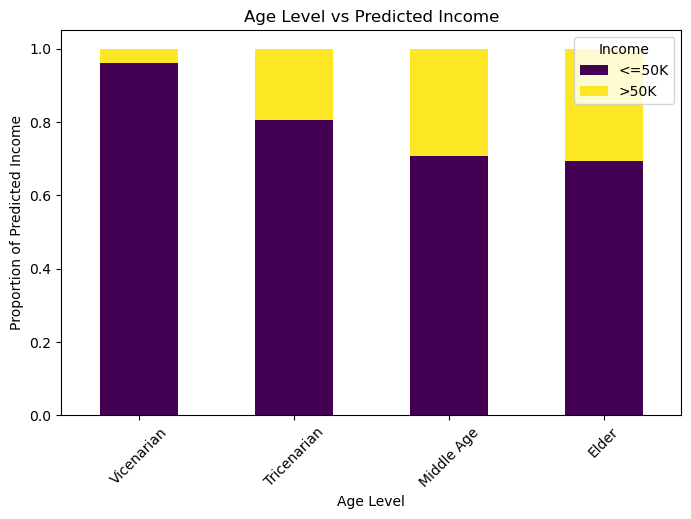

In [36]:
X_val_pred = X_val
X_val_pred["predicted_income"] = rounded
bins = [17, 28, 37, 47, X_val_pred['age'].max()]
labels = ['Vicenarian', 'Tricenarian', 'Middle Age', 'Elder']
X_val_pred['age_bin'] = pd.cut(
    X_val_pred['age'], bins=bins, labels=labels, include_lowest=True
)


age_crosstab = pd.crosstab(
    X_val_pred['age_bin'],
    X_val_pred['predicted_income'],
    normalize='index'
)

age_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Predicted Income')
plt.xlabel('Age Level')
plt.title('Age Level vs Predicted Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**We can see that older people tend to be associated with predicted income over 50,000 dollar. This is intuitive because older people have more work experience than younger people and therefore they will more likely to be paid more.**

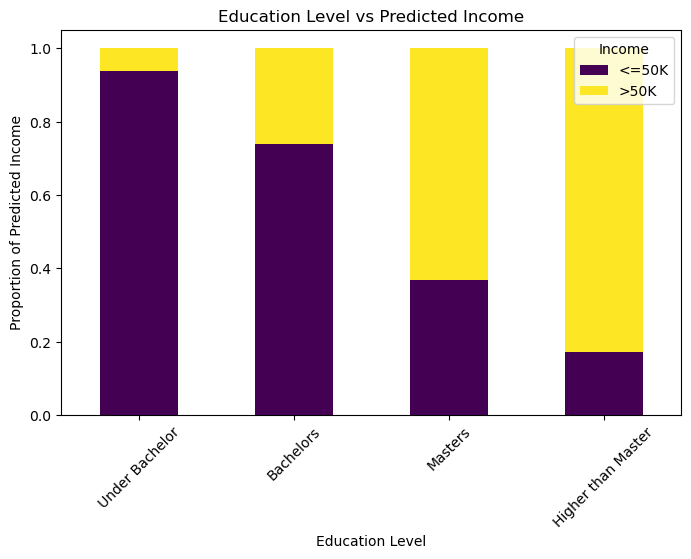

In [37]:
X_val_pred = X_val
X_val_pred["predicted_income"] = rounded
bins = [1, 9, 13, 14, X_val_pred['education-num'].max()]
labels = ['Under Bachelor', 'Bachelors', 'Masters', 'Higher than Master']
X_val_pred['education_num_bin'] = pd.cut(
    X_val_pred['education-num'], bins=bins, labels=labels, include_lowest=True
)


edu_num_crosstab = pd.crosstab(
    X_val_pred['education_num_bin'],
    X_val_pred['predicted_income'],
    normalize='index'
)

edu_num_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Predicted Income')
plt.xlabel('Education Level')
plt.title('Education Level vs Predicted Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**We can see that people with higher education level tend to be associated with predicted income over 50,000 dollar. This is intuitive since people with higher education level usaully have stronger skills and more likely to be preffered by large firms which offers high salary.**

- **From b. we know that top three categorical predictors are `marital-status`, `occupation`, and `relationship`**

/tmp/ipykernel_4127/3114341189.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
/tmp/ipykernel_4127/3114341189.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
/tmp/ipykernel_4127/3114341189.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')


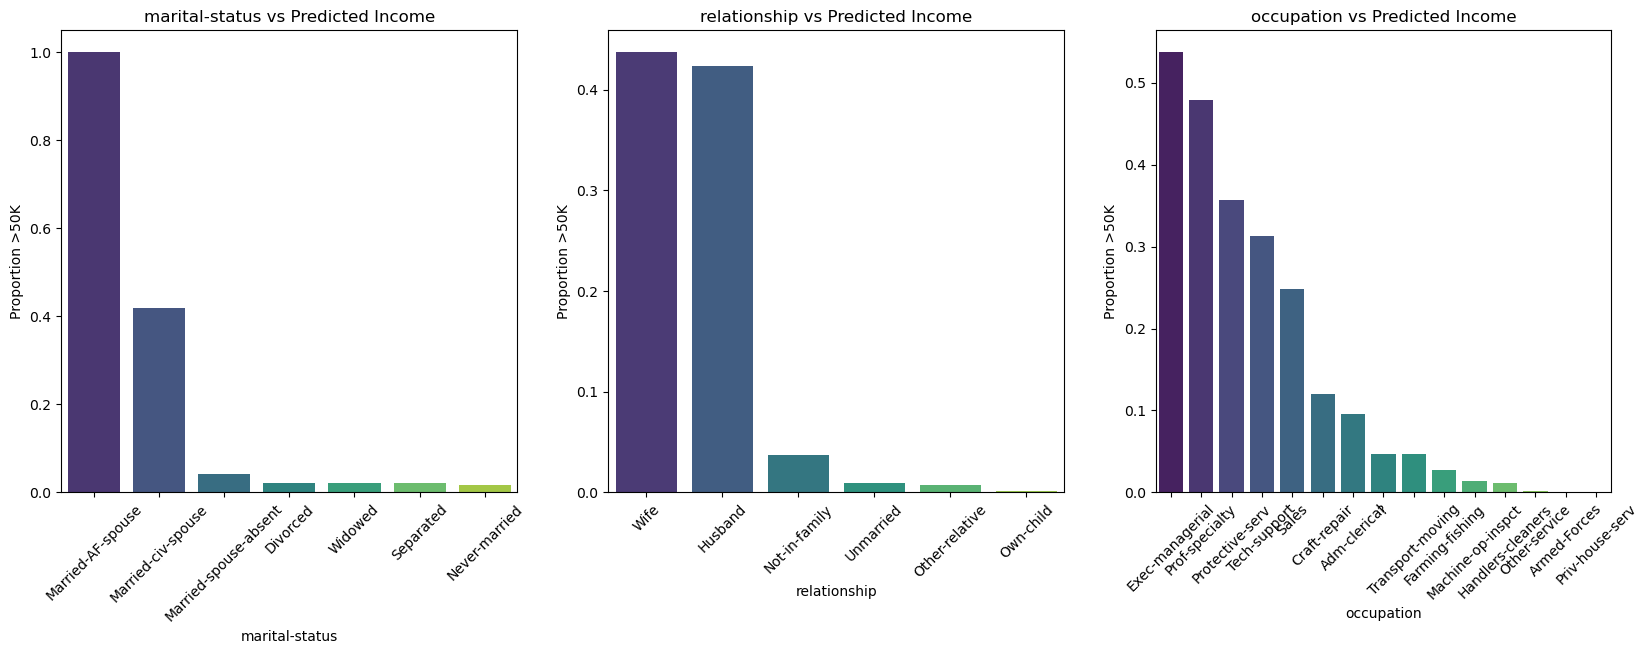

In [38]:
top_categorical = ['marital-status', 'relationship', 'occupation']
fig, axes = plt.subplots(1, 3, figsize=(20,6))
X_val_pred = X_val
X_val_pred["predicted_income"] = rounded

for i, feature in enumerate(top_categorical):

    prop_df = (X_val_pred.groupby(feature)['predicted_income'].mean().sort_values(ascending=False).reset_index())
    
    sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
    
    axes[i].set_ylabel('Proportion >50K')
    axes[i].set_xlabel(feature)
    axes[i].set_title(f'{feature} vs Predicted Income')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

**We can see from the graphs that occupations in executive management, professional specialties, protective services, and technology-related fields tend to have higher income levels. This is intuitive, as these roles typically require higher qualifications, greater responsibility, and more complex skill sets.**

### f.

### Construct a histogram of one numeric variable which is important in the model, with an overlay of income. (You may wish to use “normalize” to increase contrast.) Then construct a histogram of one numeric variable which is not important in the model, with an overlay of income. Do the histograms support the findings of the neural network?

**First we plot a histogram of a numeric important variable `capital-gain`**

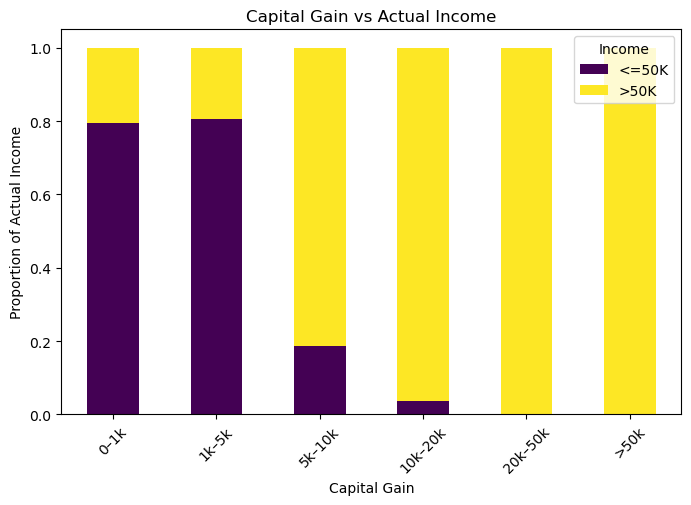

In [39]:
X_val_capt = X_val
X_val_capt['actual_income'] = y_val.values
bins = [0, 1000, 5000, 10000, 20000, 50000, X_val_capt['capital-gain'].max()]
labels = ['0–1k', '1k–5k', '5k–10k', '10k–20k', '20k–50k', '>50k']
X_val_capt['capital_gain_bin'] = pd.cut(
    X_val_capt['capital-gain'], bins=bins, labels=labels, include_lowest=True
)

capital_crosstab = pd.crosstab(
    X_val_capt['capital_gain_bin'],
    X_val_capt['actual_income'],
    normalize='index'
)

capital_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Actual Income')
plt.xlabel('Capital Gain')
plt.title('Capital Gain vs Actual Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**Then we plot a histogram of a numeric not important variable `demogweight`**

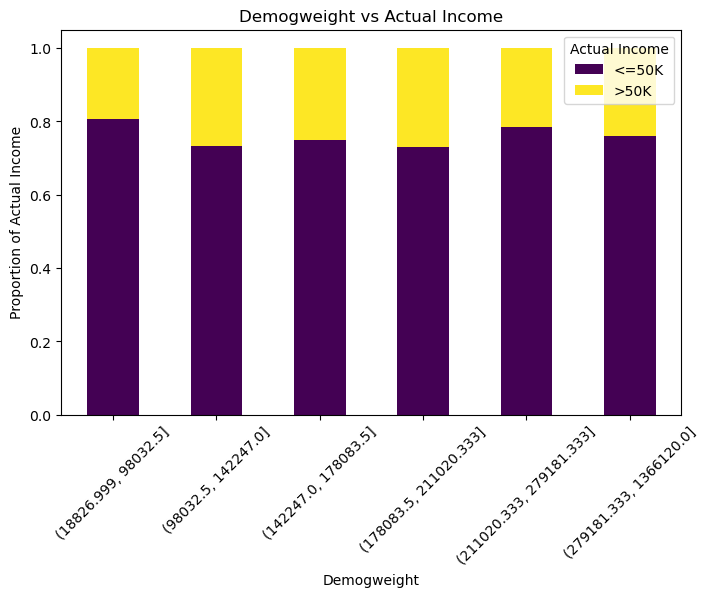

In [40]:
X_val_demo = X_val
X_val_demo['actual_income'] = y_val.values
X_val_demo['demogweight_bin'] = pd.qcut(X_val_demo['demogweight'], q=6)
demo_crosstab = pd.crosstab(
    X_val_demo['demogweight_bin'],
    X_val_demo['actual_income'],
    normalize='index'
)


demo_crosstab.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
plt.ylabel('Proportion of Actual Income')
plt.xlabel('Demogweight')
plt.title('Demogweight vs Actual Income')
plt.legend(title='Actual Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

**We can observe from the histograms that for different capital gain level, the income level differs a lot, indicating larger capital gain, more income. However, the income level does not vary too much for different demoweight level. This conclusion supports findings from neural network**

## Part Two

### Data Transformation and Re-Construction

In [78]:
data.head()

,age,workclass,demogweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K.
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K.
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K.
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K.
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K.


In [79]:
df_clean = data
df_clean = df_clean.drop(columns=['education'])
df_clean['income'] = df['income'].replace({'>50K.': 1, '<=50K.': 0})
df_clean.head()

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [80]:
print(df_clean.describe())

for c in categorical:
    print(df_clean[c].value_counts())

                age   demogweight  education-num  capital-gain  capital-loss  \
count  25000.000000  2.500000e+04   25000.000000  25000.000000   25000.00000   
mean      38.606920  1.897418e+05      10.081440   1088.579040      86.49992   
std       13.687769  1.052947e+05       2.557035   7486.621197     401.25358   
min       17.000000  1.228500e+04       1.000000      0.000000       0.00000   
25%       28.000000  1.179630e+05       9.000000      0.000000       0.00000   
50%       37.000000  1.783530e+05      10.000000      0.000000       0.00000   
75%       48.000000  2.368610e+05      12.000000      0.000000       0.00000   
max       90.000000  1.484705e+06      16.000000  99999.000000    4356.00000   

       hours-per-week        income  
count    25000.000000  25000.000000  
mean        40.407440      0.239360  
std         12.299267      0.426701  
min          1.000000      0.000000  
25%         40.000000      0.000000  
50%         40.000000      0.000000  
75%         4

**We see that `workclass`, `occupation`, and `native-country` columns have large amount of "?" values as one of their class, it is not making sense to one-hot encode "?" as a class and train the mode accordingly, therefore, we might need to interpret these "?" values as missing data, and try to transform them into meaningful values**

**First split the data into X and Y and also do the train/test split:**

In [81]:
X = df_clean.iloc[:, :13]
y = df_clean.iloc[:, -1]

In [82]:
# split the training data into train validate sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#### - Method 1: Replace "?" as Mode 

In [46]:
X_train_m1 = X_train.copy()
y_train_m1 = y_train.copy()
X_test_m1 = X_test.copy()
y_test_m1 = y_tesvt.copy()

X_train_m1['workclass'] = X_train_m1['workclass'].replace({'?': str(X['workclass'].mode().values[0])})
X_train_m1['occupation'] = X_train_m1['occupation'].replace({'?': str(X['occupation'].mode().values[0])})
X_train_m1['native-country'] = X_train_m1['native-country'].replace({'?': str(X['native-country'].mode().values[0])})

X_test_m1['workclass'] = X_test_m1['workclass'].replace({'?': str(X['workclass'].mode().values[0])})
X_test_m1['occupation'] = X_test_m1['occupation'].replace({'?': str(X['occupation'].mode().values[0])})
X_test_m1['native-country'] = X_test_m1['native-country'].replace({'?': str(X['native-country'].mode().values[0])})

In [47]:
for c in ['workclass', 'occupation', 'native-country']:
    print(X_train_m1[c].value_counts())

workclass
Private             15024
Self-emp-not-inc     1582
Local-gov            1300
State-gov             803
Self-emp-inc          684
Federal-gov           594
Without-pay             9
Never-worked            4
Name: count, dtype: int64
occupation
Prof-specialty       3682
Craft-repair         2500
Exec-managerial      2455
Adm-clerical         2341
Sales                2262
Other-service        2016
Machine-op-inspct    1243
Transport-moving      971
Handlers-cleaners     830
Farming-fishing       618
Tech-support          569
Protective-serv       405
Priv-house-serv       103
Armed-Forces            5
Name: count, dtype: int64
native-country
United-States                 18292
Mexico                          395
Philippines                     117
Canada                           85
Germany                          84
Puerto-Rico                      78
Cuba                             62
England                          61
El-Salvador                      57
South           

**Now we preprocess the data use for method 1**

In [48]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [49]:
# fit preprocessor, transform to dense arrays
X_train_m1_enc = preprocessor.fit_transform(X_train_m1)
X_test_m1_enc = preprocessor.transform(X_test_m1)

X_train_m1_enc = X_train_m1_enc.toarray()
X_test_m1_enc = X_test_m1_enc.toarray()

In [53]:
X_train_m1_enc

array([[0.1369863 , 0.13983714, 0.6       , ..., 0.        , 0.        ,
        0.        ],
       [0.20547945, 0.23062985, 0.6       , ..., 1.        , 0.        ,
        0.        ],
       [0.12328767, 0.05717255, 0.8       , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.04109589, 0.13891417, 0.53333333, ..., 0.        , 0.        ,
        0.        ],
       [0.20547945, 0.12765447, 0.8       , ..., 1.        , 0.        ,
        0.        ],
       [0.56164384, 0.08796539, 0.13333333, ..., 0.        , 0.        ,
        0.        ]], shape=(20000, 89))

In [54]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m1_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [56]:
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m1_enc, y_train_m1)

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8279 - loss: 0.3639
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8257 - loss: 0.3684
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8245 - loss: 0.3700
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8283 - loss: 0.3651
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8424 - loss: 0.3400
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8399 - loss: 0.3415
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8408 - loss: 0.3434
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8439 - loss: 0.3412
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8458 - loss: 0.3351
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8450 - loss: 0.3359
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8431 - loss: 0.3401
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8458 - loss: 0.3346
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8474 - loss: 0.3328
Epoch 5/40
1125/1125 - 2s - 1ms/step - accur

1125/1125 - 1s - 1ms/step - accuracy: 0.8578 - loss: 0.3257
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8519 - loss: 0.3269
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3228
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3245
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8549 - loss: 0.3257
Epoch 30/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8526 - loss: 0.3228
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8538 - loss: 0.3217
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8569 - loss: 0.3246
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3268
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8554 - loss: 0.3231
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3234
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3247
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8551 - loss: 0.3256
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3229
Epoc

1125/1125 - 1s - 929us/step - accuracy: 0.8515 - loss: 0.3254
Epoch 21/40
1125/1125 - 1s - 922us/step - accuracy: 0.8541 - loss: 0.3250
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3259
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8535 - loss: 0.3227
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8526 - loss: 0.3262
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8533 - loss: 0.3258
Epoch 16/40
1125/1125 - 1s - 923us/step - accuracy: 0.8537 - loss: 0.3239
Epoch 23/40
1125/1125 - 1s - 878us/step - accuracy: 0.8513 - loss: 0.3259
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8527 - loss: 0.3246
Epoch 24/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8547 - loss: 0.3212
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8513 - loss: 0.3265
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8542 - loss: 0.3258
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8520 - loss: 0.3239
Epoch 25/40
1125/1125 - 1s - 1000us/step - accuracy: 0.8525 - loss: 

1125/1125 - 1s - 1ms/step - accuracy: 0.8443 - loss: 0.3349
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8525 - loss: 0.3283
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8497 - loss: 0.3304
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8506 - loss: 0.3280
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8437 - loss: 0.3338
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8518 - loss: 0.3266
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8499 - loss: 0.3302
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8511 - loss: 0.3273
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3338
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8549 - loss: 0.3264
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8524 - loss: 0.3261
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8470 - loss: 0.3318
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8528 - loss: 0.3248
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8496 - loss: 0.3278
Epoch 9/40
1

1125/1125 - 2s - 1ms/step - accuracy: 0.8581 - loss: 0.3284
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8594 - loss: 0.3255
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8560 - loss: 0.3275
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8598 - loss: 0.3287
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8593 - loss: 0.3257
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8579 - loss: 0.3200
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8572 - loss: 0.3273
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8569 - loss: 0.3281
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8599 - loss: 0.3248
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3197
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3258
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8588 - loss: 0.3269
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8562 - loss: 0.3262
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8600 - loss: 0.3274
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8556 - loss: 0.3233
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8580 - loss: 0.3277
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8598 - loss: 0.3255
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3235
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8607 - loss: 0.3277
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3246
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8579 - loss: 0.3280
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3257
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8598 - loss: 0.3253
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3275
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3250
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8591 - loss: 0.3291
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8571 - loss: 0.3283
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8593 - loss: 0.3247
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8499 - loss: 0.3247
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8542 - loss: 0.3258
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8518 - loss: 0.3266
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8553 - loss: 0.3256
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8509 - loss: 0.3261
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8554 - loss: 0.3260
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3263
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8556 - loss: 0.3258
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8513 - loss: 0.3253
Epoch 12/40
1125/1125 - 1s - 938us/step - accuracy: 0.8521 - loss: 0.3291
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3246
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8533 - loss: 0.3255
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8518 - loss: 0.3264
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8559 - loss: 0.3261
Ep

125/125 - 0s - 1ms/step
1125/1125 - 2s - 1ms/step - accuracy: 0.8407 - loss: 0.3441
Epoch 3/40
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8572 - loss: 0.3238
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8406 - loss: 0.3451
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8459 - loss: 0.3366
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8582 - loss: 0.3214
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8259 - loss: 0.3660
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8455 - loss: 0.3394
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8461 - loss: 0.3337
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8587 - loss: 0.3218
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8404 - loss: 0.3413
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8482 - loss: 0.3366
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8492 - loss: 0.3343
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8580 - loss: 0.3222
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s 

1125/1125 - 2s - 1ms/step - accuracy: 0.8598 - loss: 0.3231
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8593 - loss: 0.3261
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8562 - loss: 0.3268
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8578 - loss: 0.3242
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8578 - loss: 0.3254
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8573 - loss: 0.3278
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8584 - loss: 0.3251
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8576 - loss: 0.3253
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8581 - loss: 0.3250
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8587 - loss: 0.3258
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8605 - loss: 0.3274
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8578 - loss: 0.3266
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8577 - loss: 0.3220
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8578 - loss: 0.3277
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8551 - loss: 0.3265
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3265
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3238
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3261
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3261
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8596 - loss: 0.3233
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8562 - loss: 0.3272
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3262
Epoch 13/40
1125/1125 - 1s - 944us/step - accuracy: 0.8568 - loss: 0.3291
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8551 - loss: 0.3262
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8546 - loss: 0.3262
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8551 - loss: 0.3280
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8594 - loss: 0.3239
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8545 - loss: 0.3264
Ep

1125/1125 - 1s - 1ms/step - accuracy: 0.8521 - loss: 0.3281
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8394 - loss: 0.3404
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8616 - loss: 0.3217
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3287
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8388 - loss: 0.3387
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8530 - loss: 0.3289
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3268
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8510 - loss: 0.3279
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8063 - loss: 0.4054
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8422 - loss: 0.3349
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3268
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8522 - loss: 0.3287
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8297 - loss: 0.3602
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - l

1125/1125 - 2s - 1ms/step - accuracy: 0.8586 - loss: 0.3287
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8558 - loss: 0.3173
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8586 - loss: 0.3227
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8533 - loss: 0.3118
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8609 - loss: 0.3254
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8593 - loss: 0.3256
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8560 - loss: 0.3107
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8527 - loss: 0.3152
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8616 - loss: 0.3257
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8526 - loss: 0.3120
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8139 - loss: 0.3922
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3159
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8614 - loss: 0.3271
125/125 - 0s - 913us/step
Epoch 1/40
1125/1125 - 1s - 

1125/1125 - 2s - 1ms/step - accuracy: 0.8508 - loss: 0.3197
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8549 - loss: 0.3126
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3133
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8447 - loss: 0.3288
Epoch 17/40
1125/1125 - 1s - 900us/step - accuracy: 0.8526 - loss: 0.3134
Epoch 30/40
1125/1125 - 1s - 891us/step - accuracy: 0.8538 - loss: 0.3123
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8511 - loss: 0.3175
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3111
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8421 - loss: 0.3310
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8544 - loss: 0.3134
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3180
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8522 - loss: 0.3119
Epoch 32/40
1125/1125 - 1s - 1000us/step - accuracy: 0.8441 - loss: 0.3269
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.31

1125/1125 - 1s - 972us/step - accuracy: 0.8468 - loss: 0.3261
Epoch 14/40
1125/1125 - 1s - 992us/step - accuracy: 0.8492 - loss: 0.3223
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8397 - loss: 0.3398
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8467 - loss: 0.3258
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8401 - loss: 0.3391
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8500 - loss: 0.3209
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8401 - loss: 0.3388
Epoch 9/40
1125/1125 - 1s - 904us/step - accuracy: 0.8474 - loss: 0.3255
Epoch 16/40
1125/1125 - 1s - 860us/step - accuracy: 0.8486 - loss: 0.3216
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8462 - loss: 0.3232
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8412 - loss: 0.3377
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8481 - loss: 0.3201
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8441 - loss: 0.3354
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8482 - loss: 0.3233


1125/1125 - 1s - 1ms/step - accuracy: 0.8551 - loss: 0.3097
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8423 - loss: 0.3348
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8378 - loss: 0.3465
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3150
Epoch 31/40
1125/1125 - 1s - 984us/step - accuracy: 0.8588 - loss: 0.3104
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8389 - loss: 0.3427
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8522 - loss: 0.3143
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3095
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8412 - loss: 0.3346
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8396 - loss: 0.3384
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3101
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8447 - loss: 0.3310
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8407 - loss: 0.3386
Epoch 8/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8537 - loss: 0.3111
Epoch 33

1125/1125 - 1s - 863us/step - accuracy: 0.8546 - loss: 0.3109
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3118
Epoch 24/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8574 - loss: 0.3065
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8553 - loss: 0.3095
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8504 - loss: 0.3168
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3128
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8578 - loss: 0.3075
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8562 - loss: 0.3089
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8519 - loss: 0.3162
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3101
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3093
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8515 - loss: 0.3161
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8548 - loss: 0.3097
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8577 - loss: 0.3058
Ep

1125/1125 - 2s - 2ms/step - accuracy: 0.8409 - loss: 0.3353
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8498 - loss: 0.3166
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8569 - loss: 0.3115
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8441 - loss: 0.3319
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8423 - loss: 0.3331
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8531 - loss: 0.3115
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8442 - loss: 0.3295
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8531 - loss: 0.3146
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8433 - loss: 0.3311
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8519 - loss: 0.3113
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8457 - loss: 0.3272
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3160
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8452 - loss: 0.3293
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8460 - loss: 0.3279
Epoch 

Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8581 - loss: 0.3060
Epoch 37/40
1125/1125 - 1s - 999us/step - accuracy: 0.8446 - loss: 0.3279
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8572 - loss: 0.3058
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8136 - loss: 0.3932
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8490 - loss: 0.3246
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8465 - loss: 0.3260
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8589 - loss: 0.3054
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8317 - loss: 0.3536
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8497 - loss: 0.3236
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8468 - loss: 0.3244
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8596 - loss: 0.3040
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8353 - loss: 0.3446
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3213
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0

1125/1125 - 1s - 1ms/step - accuracy: 0.8339 - loss: 0.3536
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3035
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3072
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8372 - loss: 0.3458
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8544 - loss: 0.3117
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8601 - loss: 0.3034
1125/1125 - 2s - 1ms/step - accuracy: 0.8588 - loss: 0.3063
Epoch 30/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8399 - loss: 0.3396
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3097
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8584 - loss: 0.3052
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8147 - loss: 0.3901
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8398 - loss: 0.3386
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8578 - loss: 0.3057
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8365 -

1125/1125 - 1s - 1ms/step - accuracy: 0.8536 - loss: 0.3064
Epoch 30/40
1125/1125 - 1s - 903us/step - accuracy: 0.8562 - loss: 0.3058
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3060
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8498 - loss: 0.3224
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8548 - loss: 0.3072
Epoch 33/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8503 - loss: 0.3181
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8562 - loss: 0.3060
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8487 - loss: 0.3214
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3181
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8574 - loss: 0.3054
Epoch 33/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8583 - loss: 0.3039
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8507 - loss: 0.3212
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8508 - loss: 0.3158
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8593 - loss: 0.3036
Ep

1125/1125 - 2s - 2ms/step - accuracy: 0.8161 - loss: 0.3855
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8541 - loss: 0.3159
Epoch 21/40
1125/1125 - 1s - 927us/step - accuracy: 0.8506 - loss: 0.3162
Epoch 20/40
1125/1125 - 1s - 977us/step - accuracy: 0.8554 - loss: 0.3113
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3153
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8381 - loss: 0.3458
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8318 - loss: 0.3536
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8531 - loss: 0.3121
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3155
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8392 - loss: 0.3419
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8513 - loss: 0.3114
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8527 - loss: 0.3146
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8428 - loss: 0.3378
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8384 - loss: 0.3447
Epoch

1125/1125 - 1s - 1ms/step - accuracy: 0.8568 - loss: 0.3055
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3051
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8582 - loss: 0.3042
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3070
Epoch 32/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8524 - loss: 0.3176
Epoch 9/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8565 - loss: 0.3090
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8595 - loss: 0.3048
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8524 - loss: 0.3155
Epoch 10/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8581 - loss: 0.3042
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3039
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3141
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8567 - loss: 0.3073
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8526 - loss: 0.3135
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3069
Epoch

1125/1125 - 2s - 2ms/step - accuracy: 0.8647 - loss: 0.2917
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8607 - loss: 0.2983
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8619 - loss: 0.2970
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8622 - loss: 0.2921
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8617 - loss: 0.2991
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8621 - loss: 0.2958
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8582 - loss: 0.3019
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8622 - loss: 0.2974
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8627 - loss: 0.2950
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3008
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8642 - loss: 0.2921
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8601 - loss: 0.2984
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8618 - loss: 0.2949
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8

1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3276
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8523 - loss: 0.3150
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8619 - loss: 0.2941
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8523 - loss: 0.3235
Epoch 5/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8594 - loss: 0.3013
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8517 - loss: 0.3142
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8615 - loss: 0.2936
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8541 - loss: 0.3130
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8629 - loss: 0.2929
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8512 - loss: 0.3199
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8589 - loss: 0.3008
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3104
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3193
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8611 - loss: 0.2999
Epoch 27

1125/1125 - 1s - 948us/step - accuracy: 0.8579 - loss: 0.3047
Epoch 16/40
1125/1125 - 1s - 946us/step - accuracy: 0.8541 - loss: 0.3104
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8593 - loss: 0.2980
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8582 - loss: 0.3084
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8609 - loss: 0.3041
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2953
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8603 - loss: 0.2966
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8618 - loss: 0.3034
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8623 - loss: 0.2961
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8599 - loss: 0.2979
1125/1125 - 2s - 1ms/step - accuracy: 0.8617 - loss: 0.3031
Epoch 19/40
125/125 - 0s - 1ms/step
1125/1125 - 3s - 3ms/step - accuracy: 0.8588 - loss: 0.3066
Epoch 15/40
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8613 - loss: 0.2955
Epoch 37/40
1125/1125 - 2s - 1ms/step - accuracy:

1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.2961
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8651 - loss: 0.2918
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3339
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8614 - loss: 0.2953
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8644 - loss: 0.2924
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8454 - loss: 0.3271
Epoch 4/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8501 - loss: 0.3231
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8623 - loss: 0.2936
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8643 - loss: 0.2904
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8488 - loss: 0.3223
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8513 - loss: 0.3188
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8651 - loss: 0.2899
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8526 - loss: 0.3149
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8642 - loss: 0.2927
Epoch 25/4

1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3111
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8651 - loss: 0.2874
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8651 - loss: 0.2828
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8616 - loss: 0.2985
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8560 - loss: 0.3092
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8560 - loss: 0.3077
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8612 - loss: 0.2961
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8635 - loss: 0.2878
Epoch 32/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8668 - loss: 0.2828
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8582 - loss: 0.3058
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8601 - loss: 0.2966
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8662 - loss: 0.2860
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8678 - loss: 0.2812
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8601 - loss: 0.3024
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3228
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8599 - loss: 0.2973
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8610 - loss: 0.2949
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8683 - loss: 0.2839
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8622 - loss: 0.2954
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8626 - loss: 0.2936
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8674 - loss: 0.2844
Epoch 40/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8508 - loss: 0.3193
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8623 - loss: 0.2939
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8632 - loss: 0.2931
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8697 - loss: 0.2828
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8628 - loss: 0.2933
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3169
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8627

1125/1125 - 1s - 1ms/step - accuracy: 0.8572 - loss: 0.3077
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8647 - loss: 0.2858
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8664 - loss: 0.2859
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8591 - loss: 0.3037
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8533 - loss: 0.3181
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8652 - loss: 0.2838
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8656 - loss: 0.2852
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8591 - loss: 0.3023
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8521 - loss: 0.3163
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8664 - loss: 0.2848
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8667 - loss: 0.2831
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8545 - loss: 0.3127
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8659 - loss: 0.2846
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8644 - loss: 0.2843
Epoch 3

1125/1125 - 2s - 2ms/step - accuracy: 0.8679 - loss: 0.2835
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8633 - loss: 0.2949
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8656 - loss: 0.2863
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8695 - loss: 0.2758
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8661 - loss: 0.2838
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8628 - loss: 0.2935
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8651 - loss: 0.2858
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8709 - loss: 0.2759
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8636 - loss: 0.2936
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8678 - loss: 0.2828
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8711 - loss: 0.2755
125/125 - 0s - 1ms/step
1125/1125 - 3s - 2ms/step - accuracy: 0.8669 - loss: 0.2823
Epoch 35/40
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8636 - loss: 0.2921
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8

1125/1125 - 1s - 1ms/step - accuracy: 0.8688 - loss: 0.2803
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8657 - loss: 0.2876
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3173
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8692 - loss: 0.2790
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8508 - loss: 0.3121
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8678 - loss: 0.2854
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3135
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8699 - loss: 0.2777
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8545 - loss: 0.3105
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8674 - loss: 0.2839
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3104
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8686 - loss: 0.2778
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3085
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8587 - loss: 0.3079
Epoch 9/

1125/1125 - 1s - 1ms/step - accuracy: 0.8615 - loss: 0.2975
Epoch 15/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8677 - loss: 0.2774
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8681 - loss: 0.2766
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8634 - loss: 0.2947
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8578 - loss: 0.3067
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8678 - loss: 0.2784
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8650 - loss: 0.2928
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8580 - loss: 0.3041
Epoch 10/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8703 - loss: 0.2760
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8709 - loss: 0.2764
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8632 - loss: 0.2919
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8709 - loss: 0.2749
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8683 - loss: 0.2762
125/125 - 0s - 986us/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.

1125/1125 - 1s - 1ms/step - accuracy: 0.8697 - loss: 0.2753
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8374 - loss: 0.3496
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8511 - loss: 0.3247
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8712 - loss: 0.2736
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8546 - loss: 0.3223
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8429 - loss: 0.3428
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8517 - loss: 0.3246
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8528 - loss: 0.3222
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8449 - loss: 0.3382
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3242
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8728 - loss: 0.2739
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8529 - loss: 0.3220
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8463 - loss: 0.3348
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8522 - loss: 0.3242
Epoch 27

1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3207
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3226
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8528 - loss: 0.3247
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8541 - loss: 0.3211
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8541 - loss: 0.3222
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8488 - loss: 0.3291
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8530 - loss: 0.3242
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3205
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3221
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8496 - loss: 0.3285
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8526 - loss: 0.3241
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8542 - loss: 0.3208
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8543 - loss: 0.3223
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8504 - loss: 0.3274
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3245
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8508 - loss: 0.3261
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8419 - loss: 0.3434
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8528 - loss: 0.3235
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8498 - loss: 0.3258
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8546 - loss: 0.3216
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8432 - loss: 0.3382
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8520 - loss: 0.3230
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8487 - loss: 0.3256
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8539 - loss: 0.3218
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8469 - loss: 0.3346
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3226
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3210
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8488

1125/1125 - 2s - 2ms/step - accuracy: 0.8317 - loss: 0.3561
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8545 - loss: 0.3197
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8511 - loss: 0.3273
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8379 - loss: 0.3464
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3195
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8500 - loss: 0.3260
Epoch 10/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8553 - loss: 0.3204
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8424 - loss: 0.3406
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3197
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8504 - loss: 0.3249
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3370
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3196
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8507 - loss: 0.3245
Epoch 12/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8539 - loss: 0.3201
Epoch 33/

1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3210
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3216
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8543 - loss: 0.3226
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8554 - loss: 0.3181
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3212
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8530 - loss: 0.3224
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8558 - loss: 0.3184
125/125 - 0s - 1ms/step
1125/1125 - 1s - 1ms/step - accuracy: 0.8543 - loss: 0.3211
Epoch 35/40
Epoch 1/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8536 - loss: 0.3220
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8532 - loss: 0.3220
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3211
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3212
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8113 - loss: 0.3949
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.85

1125/1125 - 2s - 2ms/step - accuracy: 0.8103 - loss: 0.3934
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3176
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3219
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8322 - loss: 0.3542
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8396 - loss: 0.3443
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3174
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8532 - loss: 0.3218
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8409 - loss: 0.3426
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8438 - loss: 0.3380
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8554 - loss: 0.3172
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3344
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3168
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3218
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8446 - loss: 0.3354
Epoch 5/40

1125/1125 - 2s - 2ms/step - accuracy: 0.8543 - loss: 0.3201
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3193
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3177
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8509 - loss: 0.3240
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3198
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3192
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3175
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3195
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3188
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8521 - loss: 0.3226
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8558 - loss: 0.3175
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8541 - loss: 0.3193
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8519 - loss: 0.3225
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8555 - loss: 0.3171
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3191
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8564 - loss: 0.3164
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8506 - loss: 0.3262
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3215
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8557 - loss: 0.3189
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3160
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3180
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8570 - loss: 0.3160
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8546 - loss: 0.3208
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8519 - loss: 0.3251
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3184
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8529 - loss: 0.3234
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3207
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8120

1125/1125 - 1s - 1ms/step - accuracy: 0.8580 - loss: 0.3133
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3276
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8579 - loss: 0.3159
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3130
Epoch 37/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8503 - loss: 0.3245
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8494 - loss: 0.3269
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8578 - loss: 0.3156
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3258
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8584 - loss: 0.3159
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8583 - loss: 0.3130
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8516 - loss: 0.3236
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8498 - loss: 0.3253
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8576 - loss: 0.3154
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8589 - loss: 0.3124
Epoch 3

1125/1125 - 1s - 1ms/step - accuracy: 0.8572 - loss: 0.3157
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3194
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8579 - loss: 0.3165
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8567 - loss: 0.3181
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8579 - loss: 0.3151
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3161
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3150
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8575 - loss: 0.3161
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8537 - loss: 0.3194
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8584 - loss: 0.3145
Epoch 38/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8555 - loss: 0.3176
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8543 - loss: 0.3191
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8565 - loss: 0.3163
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8

1125/1125 - 1s - 1ms/step - accuracy: 0.8577 - loss: 0.3161
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8362 - loss: 0.3520
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8307 - loss: 0.3588
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8557 - loss: 0.3165
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8566 - loss: 0.3160
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8368 - loss: 0.3501
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8337 - loss: 0.3554
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3165
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3154
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8384 - loss: 0.3476
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8349 - loss: 0.3530
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8579 - loss: 0.3156
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8388 - loss: 0.3459
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8558 - loss: 0.3168
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8351 - loss: 0.3537
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8402 - loss: 0.3437
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8427 - loss: 0.3354
1125/1125 - 3s - 2ms/step - accuracy: 0.8447 - loss: 0.3300
125/125 - 0s - 1ms/step
125/125 - 0s - 1ms/step
Epoch 1/40
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8369 - loss: 0.3506
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8428 - loss: 0.3422
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8387 - loss: 0.3478
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.7678 - loss: 0.4594
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.7628 - loss: 0.4764
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8373 - loss: 0.3458
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8126 - loss: 0.4026
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8423 - loss: 0.3407
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8018 - loss: 0.4165
Epoch 3/40
1125/1125 - 2s - 1ms/st

1125/1125 - 1s - 1ms/step - accuracy: 0.8456 - loss: 0.3339
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3284
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7696 - loss: 0.4712
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8417 - loss: 0.3345
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8434 - loss: 0.3334
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8461 - loss: 0.3278
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8064 - loss: 0.4109
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8454 - loss: 0.3336
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3330
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8476 - loss: 0.3276
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8131 - loss: 0.3926
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8449 - loss: 0.3327
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8474 - loss: 0.3270
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8202 - loss: 0.3810
Epoch 5

1125/1125 - 2s - 1ms/step - accuracy: 0.8428 - loss: 0.3385
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8431 - loss: 0.3398
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8433 - loss: 0.3349
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8434 - loss: 0.3350
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8442 - loss: 0.3376
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8426 - loss: 0.3396
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8444 - loss: 0.3346
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8421 - loss: 0.3349
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8414 - loss: 0.3371
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8420 - loss: 0.3389
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8428 - loss: 0.3345
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8431 - loss: 0.3365
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8433 - loss: 0.3379
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8422 - loss: 0.3340
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8356 - loss: 0.3555
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8429 - loss: 0.3366
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8143 - loss: 0.3935
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8370 - loss: 0.3508
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8369 - loss: 0.3514
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8430 - loss: 0.3356
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8192 - loss: 0.3815
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8372 - loss: 0.3487
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8385 - loss: 0.3489
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8433 - loss: 0.3352
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8233 - loss: 0.3732
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8379 - loss: 0.3472
Epoch 13/40
1125/1125 - 1s - 953us/step - accuracy: 0.8434 - loss: 0.3343
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8391 - loss: 0.3455
Epoch 

1125/1125 - 2s - 2ms/step - accuracy: 0.8457 - loss: 0.3306
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8337 - loss: 0.3564
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8467 - loss: 0.3278
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8444 - loss: 0.3306
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8461 - loss: 0.3298
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8349 - loss: 0.3528
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8469 - loss: 0.3272
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3296
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8371 - loss: 0.3496
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8445 - loss: 0.3300
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8466 - loss: 0.3271
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8383 - loss: 0.3471
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7658 - loss: 0.4707
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.846

1125/1125 - 3s - 2ms/step - accuracy: 0.8452 - loss: 0.3278
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8437 - loss: 0.3358
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8403 - loss: 0.3377
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8444 - loss: 0.3342
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8463 - loss: 0.3280
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8418 - loss: 0.3374
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8431 - loss: 0.3349
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8482 - loss: 0.3272
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8450 - loss: 0.3333
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8399 - loss: 0.3372
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8421 - loss: 0.3348
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8469 - loss: 0.3267
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3328
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8411 - loss: 0.3364
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8356 - loss: 0.3539
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8424 - loss: 0.3426
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8416 - loss: 0.3408
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8452 - loss: 0.3337
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8428 - loss: 0.3414
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8358 - loss: 0.3512
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8428 - loss: 0.3401
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8379 - loss: 0.3489
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8420 - loss: 0.3399
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8451 - loss: 0.3330
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8387 - loss: 0.3467
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8421 - loss: 0.3391
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8441 - loss: 0.3327
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8434 - loss: 0.3391
Epoc

125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8256 - loss: 0.3764
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8461 - loss: 0.3303
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8418 - loss: 0.3422
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8290 - loss: 0.3682
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7702 - loss: 0.4646
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8442 - loss: 0.3293
Epoch 40/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8420 - loss: 0.3411
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8300 - loss: 0.3623
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8104 - loss: 0.4033
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8443 - loss: 0.3292
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8332 - loss: 0.3581
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8197 - loss: 0.3848
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8434 - loss: 0.3398
Epoch 16/40
1125/1125 - 2

1125/1125 - 2s - 1ms/step - accuracy: 0.8422 - loss: 0.3339
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8466 - loss: 0.3309
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8455 - loss: 0.3292
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7645 - loss: 0.4682
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8441 - loss: 0.3334
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8466 - loss: 0.3300
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8047 - loss: 0.4097
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8439 - loss: 0.3328
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8449 - loss: 0.3289
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8150 - loss: 0.3910
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8428 - loss: 0.3326
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3281
Epoch 37/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8457 - loss: 0.3298
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8184 - loss: 0.3802
Epoch 5

1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3388
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8442 - loss: 0.3334
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8443 - loss: 0.3381
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8432 - loss: 0.3388
Epoch 16/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8424 - loss: 0.3333
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3325
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8428 - loss: 0.3327
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8438 - loss: 0.3324
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8438 - loss: 0.3365
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8441 - loss: 0.3375
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8428 - loss: 0.3330
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8438 - loss: 0.3361
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8429 - loss: 0.3371
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8433 - loss: 0.3320
Epoc

125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8522 - loss: 0.3194
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3085
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8467 - loss: 0.3295
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8007 - loss: 0.4101
Epoch 2/40
1125/1125 - 1s - 932us/step - accuracy: 0.8576 - loss: 0.3074
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8307 - loss: 0.3590
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8528 - loss: 0.3183
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8577 - loss: 0.3070
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8517 - loss: 0.3242
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8388 - loss: 0.3451
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3179
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8569 - loss: 0.3064
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8534 - loss: 0.3195
Epoch 7/40
1125/1125 - 1s - 1ms/step - accur

Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8532 - loss: 0.3161
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8594 - loss: 0.3021
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8604 - loss: 0.3001
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7981 - loss: 0.4147
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3019
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8619 - loss: 0.2996
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8294 - loss: 0.3605
Epoch 3/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8545 - loss: 0.3150
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8600 - loss: 0.3014
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8622 - loss: 0.2990
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8376 - loss: 0.3465
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8542 - loss: 0.3141
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8599 - loss: 0.3012
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8618 - loss: 0.2

1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3109
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8585 - loss: 0.3057
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8604 - loss: 0.3023
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8594 - loss: 0.3052
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8558 - loss: 0.3103
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3016
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.3041
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8578 - loss: 0.3053
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3097
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8605 - loss: 0.3036
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3095
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8604 - loss: 0.3014
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8619 - loss: 0.3027
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8538 - loss: 0.3090
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8537 - loss: 0.3130
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3063
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8550 - loss: 0.3115
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3061
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8499 - loss: 0.3226
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8552 - loss: 0.3115
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8559 - loss: 0.3117
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8572 - loss: 0.3064
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8516 - loss: 0.3202
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8549 - loss: 0.3114
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3103
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.3188
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3106
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8574 - loss: 0.3051
Epoch 2

1125/1125 - 2s - 1ms/step - accuracy: 0.8627 - loss: 0.2970
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8546 - loss: 0.3125
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8652 - loss: 0.2927
125/125 - 0s - 2ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8639 - loss: 0.2973
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3116
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8521 - loss: 0.3183
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8628 - loss: 0.2966
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3098
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8146 - loss: 0.3903
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8527 - loss: 0.3164
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8568 - loss: 0.3100
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8379 - loss: 0.3475
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3147
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8638 -

1125/1125 - 1s - 1ms/step - accuracy: 0.8609 - loss: 0.2979
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8626 - loss: 0.2932
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8081 - loss: 0.4027
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8624 - loss: 0.2975
Epoch 28/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8622 - loss: 0.2962
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8639 - loss: 0.2933
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8337 - loss: 0.3518
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8618 - loss: 0.2975
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8617 - loss: 0.2964
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8640 - loss: 0.2923
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8430 - loss: 0.3371
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8646 - loss: 0.2965
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8637 - loss: 0.2959
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8666 - loss: 0.2920
Epoch 3

1125/1125 - 2s - 2ms/step - accuracy: 0.8570 - loss: 0.3078
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8612 - loss: 0.3006
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8573 - loss: 0.3053
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8585 - loss: 0.3038
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8574 - loss: 0.3065
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8588 - loss: 0.3005
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8584 - loss: 0.3045
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8583 - loss: 0.3062
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8587 - loss: 0.3003
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8601 - loss: 0.3043
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8578 - loss: 0.3029
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8593 - loss: 0.3058
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8605 - loss: 0.2991
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8604 - loss: 0.3035
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8504 - loss: 0.3194
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8596 - loss: 0.3013
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8526 - loss: 0.3165
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8538 - loss: 0.3147
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3137
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8545 - loss: 0.3133
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8554 - loss: 0.3164
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8612 - loss: 0.3002
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8557 - loss: 0.3118
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3112
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8543 - loss: 0.3141
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8634 - loss: 0.2992
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8562 - loss: 0.3093
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8579 - loss: 0.3091
Epoch 9/40

1125/1125 - 2s - 1ms/step - accuracy: 0.8681 - loss: 0.2836
Epoch 37/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8464 - loss: 0.3303
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8663 - loss: 0.2856
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8687 - loss: 0.2826
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8682 - loss: 0.2832
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8504 - loss: 0.3240
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8697 - loss: 0.2822
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8684 - loss: 0.2850
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8677 - loss: 0.2826
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8528 - loss: 0.3185
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8688 - loss: 0.2818
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8675 - loss: 0.2836
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8685 - loss: 0.2814
Epoch 40/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3173
Epoch 7

1125/1125 - 3s - 3ms/step - accuracy: 0.8642 - loss: 0.2935
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8635 - loss: 0.2927
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8701 - loss: 0.2845
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8625 - loss: 0.2948
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8656 - loss: 0.2918
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8630 - loss: 0.2937
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8656 - loss: 0.2914
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8673 - loss: 0.2843
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8639 - loss: 0.2914
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8642 - loss: 0.2921
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8652 - loss: 0.2915
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8691 - loss: 0.2839
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8683 - loss: 0.2902
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8643 - loss: 0.2919
Epoc

1125/1125 - 1s - 922us/step - accuracy: 0.8645 - loss: 0.2911
Epoch 25/40
1125/1125 - 1s - 934us/step - accuracy: 0.8672 - loss: 0.2843
Epoch 32/40
1125/1125 - 1s - 912us/step - accuracy: 0.8658 - loss: 0.2914
Epoch 26/40
1125/1125 - 1s - 916us/step - accuracy: 0.8681 - loss: 0.2840
Epoch 33/40
1125/1125 - 1s - 911us/step - accuracy: 0.8649 - loss: 0.2901
Epoch 27/40
1125/1125 - 1s - 937us/step - accuracy: 0.8679 - loss: 0.2832
Epoch 34/40
1125/1125 - 1s - 912us/step - accuracy: 0.8651 - loss: 0.2898
Epoch 28/40
1125/1125 - 1s - 919us/step - accuracy: 0.8682 - loss: 0.2838
Epoch 35/40
1125/1125 - 1s - 924us/step - accuracy: 0.8677 - loss: 0.2882
Epoch 29/40
1125/1125 - 1s - 948us/step - accuracy: 0.8697 - loss: 0.2826
Epoch 36/40
1125/1125 - 1s - 926us/step - accuracy: 0.8664 - loss: 0.2874
Epoch 30/40
1125/1125 - 1s - 922us/step - accuracy: 0.8703 - loss: 0.2817
Epoch 37/40
1125/1125 - 1s - 924us/step - accuracy: 0.8675 - loss: 0.2870
Epoch 31/40
1125/1125 - 1s - 939us/step - accuracy

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'model__lr': [0.01, 0.001], 'model__optimizer': ['RMSprop', 'sgd', ...], 'model__units': [16, 32, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...x7fe99c427f60>


In [57]:
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)

Best params: {'model__lr': 0.001, 'model__optimizer': 'Adam', 'model__units': 32}
Best CV acc: 0.85335


#### - Method 2: Delete "?" values

In [95]:
X_train_m2 = X_train.copy()
y_train_m2 = y_train.copy()
X_test_m2 = X_test.copy()
y_test_m2 = y_test.copy()

X_train_m2 = X_train_m2[X_train_m2['workclass'] != '?']
X_train_m2 = X_train_m2[X_train_m2['occupation'] != '?']
X_train_m2 = X_train_m2[X_train_m2['native-country'] != '?']

X_test_m2 = X_test_m2[X_test_m2['workclass'] != '?']
X_test_m2 = X_test_m2[X_test_m2['occupation'] != '?']
X_test_m2 = X_test_m2[X_test_m2['native-country'] != '?']

# drop the corresponding y rows (index-aligned, order preserved)
y_train_m2 = y_train_m2.loc[X_train_m2.index]
y_test_m2  = y_test_m2.loc[X_test_m2.index]

In [96]:
for c in ['workclass', 'occupation', 'native-country']:
    print(X_train_m2[c].value_counts())

workclass
Private             13657
Self-emp-not-inc     1556
Local-gov            1283
State-gov             794
Self-emp-inc          666
Federal-gov           584
Without-pay             9
Name: count, dtype: int64
occupation
Prof-specialty       2494
Craft-repair         2463
Exec-managerial      2415
Adm-clerical         2314
Sales                2221
Other-service        1972
Machine-op-inspct    1216
Transport-moving      958
Handlers-cleaners     822
Farming-fishing       614
Tech-support          557
Protective-serv       400
Priv-house-serv        98
Armed-Forces            5
Name: count, dtype: int64
native-country
United-States                 16938
Mexico                          370
Philippines                     113
Germany                          78
Canada                           77
Puerto-Rico                      76
Cuba                             60
England                          58
India                            54
El-Salvador                      54
South 

In [97]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [98]:
# fit preprocessor, transform to dense arrays
X_train_m2_enc = preprocessor.fit_transform(X_train_m2)
X_test_m2_enc = preprocessor.transform(X_test_m2)

X_train_m2_enc = X_train_m2_enc.toarray()
X_test_m2_enc = X_test_m2_enc.toarray()

In [99]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m2_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [100]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m2_enc, y_train_m2)
"""

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8242 - loss: 0.3718
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8236 - loss: 0.3725
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8267 - loss: 0.3703
Epoch 2/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8268 - loss: 0.3709
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8375 - loss: 0.3492
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8396 - loss: 0.3488
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8424 - loss: 0.3418
Epoch 4/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8396 - loss: 0.3504
Epoch 3/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8380 - loss: 0.3479
Epoch 3/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8422 - loss: 0.3430
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8404 - loss: 0.3377
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8418 - loss: 0.3412
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8416 - loss: 0.3436
Epoch 4/40
1044/1044 - 2s - 2ms/step - accur

1044/1044 - 3s - 2ms/step - accuracy: 0.8498 - loss: 0.3301
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8511 - loss: 0.3304
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8492 - loss: 0.3297
Epoch 30/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8536 - loss: 0.3303
Epoch 31/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8501 - loss: 0.3282
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8540 - loss: 0.3306
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8538 - loss: 0.3310
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8507 - loss: 0.3279
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8491 - loss: 0.3290
Epoch 31/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3314
Epoch 32/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8504 - loss: 0.3272
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8521 - loss: 0.3313
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8520 - loss: 0.3306
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8478 - loss: 0.3283
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8503 - loss: 0.3287
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8501 - loss: 0.3311
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8495 - loss: 0.3290
Epoch 20/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8496 - loss: 0.3313
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8508 - loss: 0.3266
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8503 - loss: 0.3305
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8487 - loss: 0.3288
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8495 - loss: 0.3297
Epoch 22/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8493 - loss: 0.3312
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8504 - loss: 0.3277
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8461 - loss: 0.3295
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8492 - loss: 0.3303
Epoch 23/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8518 - loss: 0.3276
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8494 - loss: 0.3288
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8476 - loss: 0.3352
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8414 - loss: 0.3447
Epoch 4/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8453 - loss: 0.3386
Epoch 6/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8451 - loss: 0.3360
Epoch 10/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8492 - loss: 0.3322
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8417 - loss: 0.3404
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3373
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8441 - loss: 0.3362
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8486 - loss: 0.3329
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8429 - loss: 0.3384
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8471 - loss: 0.3326
Epoch 11/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8441 - loss: 0.3377
Epoch 8/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8462 - loss: 0.3347
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8455 - loss: 0.3369
Epoch 7/40
1

1044/1044 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3298
Epoch 38/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8529 - loss: 0.3325
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8558 - loss: 0.3295
Epoch 38/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8495 - loss: 0.3306
Epoch 39/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8507 - loss: 0.3308
Epoch 31/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8540 - loss: 0.3292
Epoch 39/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8546 - loss: 0.3313
Epoch 36/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8557 - loss: 0.3274
Epoch 40/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8511 - loss: 0.3291
Epoch 32/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8480 - loss: 0.3300
Epoch 40/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8546 - loss: 0.3299
116/116 - 0s - 2ms/step
1044/1044 - 2s - 2ms/step - accuracy: 0.8516 - loss: 0.3303
Epoch 33/40
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8496 - loss: 0.3301
116/116 - 0s - 4ms/step
1044/1044 - 5s - 5ms/step - a

1044/1044 - 5s - 5ms/step - accuracy: 0.8509 - loss: 0.3327
Epoch 20/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8548 - loss: 0.3290
Epoch 19/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8555 - loss: 0.3287
Epoch 30/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8524 - loss: 0.3310
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3316
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8529 - loss: 0.3280
Epoch 31/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8526 - loss: 0.3322
Epoch 27/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8516 - loss: 0.3271
Epoch 20/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8526 - loss: 0.3316
Epoch 22/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8522 - loss: 0.3316
Epoch 28/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8523 - loss: 0.3309
Epoch 23/40
1044/1044 - 6s - 6ms/step - accuracy: 0.8544 - loss: 0.3280
Epoch 32/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8532 - loss: 0.3279
Epoch 21/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8518 - loss: 0.3306
Epoc

1044/1044 - 4s - 3ms/step - accuracy: 0.8489 - loss: 0.3316
Epoch 8/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8456 - loss: 0.3374
Epoch 9/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8510 - loss: 0.3290
Epoch 17/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8455 - loss: 0.3374
Epoch 10/40
1044/1044 - 7s - 7ms/step - accuracy: 0.8478 - loss: 0.3348
Epoch 14/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8488 - loss: 0.3319
Epoch 9/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8542 - loss: 0.3288
Epoch 18/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8490 - loss: 0.3329
Epoch 15/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8542 - loss: 0.3279
Epoch 19/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8487 - loss: 0.3313
Epoch 10/40
1044/1044 - 6s - 6ms/step - accuracy: 0.8458 - loss: 0.3372
Epoch 11/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8541 - loss: 0.3263
Epoch 20/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8488 - loss: 0.3307
Epoch 11/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8491 - loss: 0.3333
Epoch 1

1044/1044 - 3s - 2ms/step - accuracy: 0.8511 - loss: 0.3343
Epoch 38/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8242 - loss: 0.3747
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8543 - loss: 0.3260
Epoch 38/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8396 - loss: 0.3441
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8514 - loss: 0.3317
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8359 - loss: 0.3505
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8548 - loss: 0.3263
Epoch 39/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8394 - loss: 0.3451
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8563 - loss: 0.3269
Epoch 40/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8432 - loss: 0.3410
Epoch 5/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8521 - loss: 0.3339
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8437 - loss: 0.3417
Epoch 5/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8453 - loss: 0.3380
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8434 - loss: 0.3400
Epoch 6/40


1044/1044 - 4s - 3ms/step - accuracy: 0.8564 - loss: 0.3292
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8528 - loss: 0.3316
Epoch 25/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8543 - loss: 0.3304
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8543 - loss: 0.3304
Epoch 26/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8551 - loss: 0.3336
Epoch 26/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8551 - loss: 0.3300
Epoch 34/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8547 - loss: 0.3319
Epoch 27/40
1044/1044 - 6s - 6ms/step - accuracy: 0.8565 - loss: 0.3312
Epoch 27/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8546 - loss: 0.3322
Epoch 35/40
1044/1044 - 7s - 6ms/step - accuracy: 0.8543 - loss: 0.3306
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8545 - loss: 0.3327
Epoch 28/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8545 - loss: 0.3281
Epoch 36/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8523 - loss: 0.3312
Epoch 34/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8543 - loss: 0.3311
Epoc

1044/1044 - 3s - 3ms/step - accuracy: 0.8498 - loss: 0.3333
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3327
Epoch 13/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8540 - loss: 0.3302
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8524 - loss: 0.3339
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8511 - loss: 0.3332
Epoch 23/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8501 - loss: 0.3322
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8535 - loss: 0.3287
Epoch 22/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8540 - loss: 0.3313
Epoch 24/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8513 - loss: 0.3327
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3286
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3333
Epoch 16/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8529 - loss: 0.3341
Epoch 15/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8562 - loss: 0.3294
Epoch 24/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8522 - loss: 0.3347
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8440 - loss: 0.3384
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8077 - loss: 0.4003
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8487 - loss: 0.3316
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8467 - loss: 0.3372
Epoch 12/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8586 - loss: 0.3282
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8596 - loss: 0.3252
1044/1044 - 3s - 3ms/step - accuracy: 0.8506 - loss: 0.3325
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8284 - loss: 0.3629
Epoch 3/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8495 - loss: 0.3379
Epoch 13/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8498 - loss: 0.3323
Epoch 13/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8322 - loss: 0.3566
Epoch 4/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8502 - loss: 0.3354
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8136 - loss: 0.3961
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8517 

1044/1044 - 3s - 3ms/step - accuracy: 0.8567 - loss: 0.3321
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8484 - loss: 0.3246
Epoch 31/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8468 - loss: 0.3231
Epoch 27/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8560 - loss: 0.3256
Epoch 40/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8545 - loss: 0.3307
116/116 - 0s - 1ms/step
1044/1044 - 3s - 3ms/step - accuracy: 0.8468 - loss: 0.3238
Epoch 32/40
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8471 - loss: 0.3219
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8592 - loss: 0.3271
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8123 - loss: 0.3950
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8503 - loss: 0.3227
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8490 - loss: 0.3202
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8309 - loss: 0.3591
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8060 - loss: 0.4011
Epoch 2/40
1044/1044 - 2s - 2ms/

1044/1044 - 3s - 2ms/step - accuracy: 0.8446 - loss: 0.3300
Epoch 18/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8499 - loss: 0.3242
Epoch 29/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8432 - loss: 0.3308
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8481 - loss: 0.3214
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8455 - loss: 0.3282
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8454 - loss: 0.3290
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8484 - loss: 0.3216
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8496 - loss: 0.3199
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8455 - loss: 0.3274
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8453 - loss: 0.3276
Epoch 18/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8495 - loss: 0.3205
Epoch 30/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8496 - loss: 0.3215
Epoch 31/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8464 - loss: 0.3251
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8464 - loss: 0.3269
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8335 - loss: 0.3491
Epoch 6/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8450 - loss: 0.3306
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8368 - loss: 0.3472
Epoch 7/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8449 - loss: 0.3302
Epoch 17/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8364 - loss: 0.3487
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8434 - loss: 0.3302
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8374 - loss: 0.3447
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8470 - loss: 0.3281
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8450 - loss: 0.3294
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8383 - loss: 0.3470
Epoch 6/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8372 - loss: 0.3448
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3271
Epoch 19/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8468 - loss: 0.3274
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8374 - loss: 0.3444
Epoch 10/4

1044/1044 - 2s - 2ms/step - accuracy: 0.8328 - loss: 0.3554
Epoch 4/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8328 - loss: 0.3523
Epoch 4/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8494 - loss: 0.3242
Epoch 35/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8529 - loss: 0.3158
Epoch 35/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8335 - loss: 0.3516
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8349 - loss: 0.3497
Epoch 5/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8473 - loss: 0.3223
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8349 - loss: 0.3493
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8380 - loss: 0.3454
Epoch 6/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8513 - loss: 0.3158
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8479 - loss: 0.3214
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8370 - loss: 0.3471
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8524 - loss: 0.3161
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8356 - loss: 0.3445
Epoch 7/40


1044/1044 - 2s - 2ms/step - accuracy: 0.8485 - loss: 0.3222
Epoch 23/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8488 - loss: 0.3184
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8526 - loss: 0.3182
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8496 - loss: 0.3212
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8484 - loss: 0.3224
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8516 - loss: 0.3185
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8517 - loss: 0.3171
Epoch 33/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8511 - loss: 0.3194
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8489 - loss: 0.3221
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8501 - loss: 0.3176
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8492 - loss: 0.3194
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8494 - loss: 0.3212
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8511 - loss: 0.3201
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3183
Epoc

1044/1044 - 3s - 2ms/step - accuracy: 0.8486 - loss: 0.3249
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8464 - loss: 0.3253
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8448 - loss: 0.3331
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8414 - loss: 0.3386
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8473 - loss: 0.3261
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8470 - loss: 0.3243
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8441 - loss: 0.3319
Epoch 13/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8422 - loss: 0.3350
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8456 - loss: 0.3244
Epoch 22/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8475 - loss: 0.3240
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8452 - loss: 0.3279
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8437 - loss: 0.3336
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8482 - loss: 0.3225
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8450 - loss: 0.3282
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8401 - loss: 0.3386
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8543 - loss: 0.3133
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8558 - loss: 0.3067
116/116 - 0s - 4ms/step
1044/1044 - 2s - 2ms/step - accuracy: 0.8426 - loss: 0.3366
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8376 - loss: 0.3422
Epoch 9/40
Epoch 1/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8544 - loss: 0.3125
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8389 - loss: 0.3401
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8455 - loss: 0.3352
Epoch 11/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8082 - loss: 0.4025
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8413 - loss: 0.3343
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8162 - loss: 0.3921
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8400 - loss: 0.3411
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8304 - loss: 0.3626
Epoch 3/40
1044/1044 - 2s - 2ms/st

1044/1044 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3174
Epoch 37/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8476 - loss: 0.3200
Epoch 26/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3165
Epoch 27/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8515 - loss: 0.3163
Epoch 38/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8101 - loss: 0.3949
Epoch 2/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8480 - loss: 0.3180
Epoch 28/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8529 - loss: 0.3173
Epoch 28/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8500 - loss: 0.3179
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8322 - loss: 0.3595
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8516 - loss: 0.3184
Epoch 29/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8356 - loss: 0.3500
Epoch 4/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8520 - loss: 0.3161
Epoch 30/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8499 - loss: 0.3167
Epoch 29/40
1044/1044 - 4s - 4ms/step - accu

1044/1044 - 3s - 3ms/step - accuracy: 0.8432 - loss: 0.3341
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8514 - loss: 0.3152
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8532 - loss: 0.3169
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8461 - loss: 0.3298
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8440 - loss: 0.3305
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8538 - loss: 0.3123
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8520 - loss: 0.3152
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8449 - loss: 0.3278
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8525 - loss: 0.3135
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8453 - loss: 0.3292
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8513 - loss: 0.3150
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8525 - loss: 0.3123
Epoch 34/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8457 - loss: 0.3287
Epoch 18/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8455 - loss: 0.3282
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8265 - loss: 0.3634
Epoch 3/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8566 - loss: 0.3062
1044/1044 - 3s - 3ms/step - accuracy: 0.8508 - loss: 0.3199
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8429 - loss: 0.3297
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8335 - loss: 0.3554
Epoch 4/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8517 - loss: 0.3186
Epoch 22/40
116/116 - 0s - 2ms/step
1044/1044 - 2s - 2ms/step - accuracy: 0.8443 - loss: 0.3276
Epoch 16/40
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8346 - loss: 0.3503
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8453 - loss: 0.3260
Epoch 17/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8501 - loss: 0.3185
Epoch 23/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8102 - loss: 0.3961
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8358 - loss: 0.3476
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8522 - loss: 0.3146
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8464 -

1044/1044 - 3s - 3ms/step - accuracy: 0.8492 - loss: 0.3261
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8540 - loss: 0.3123
Epoch 29/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8419 - loss: 0.3392
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8526 - loss: 0.3141
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8484 - loss: 0.3236
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8424 - loss: 0.3335
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8490 - loss: 0.3167
Epoch 34/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8532 - loss: 0.3128
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8452 - loss: 0.3321
Epoch 6/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8531 - loss: 0.3212
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3124
Epoch 31/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8515 - loss: 0.3127
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8543 - loss: 0.3135
Epoch 32/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8471 - loss: 0.3308
Epoch 7/4

1044/1044 - 2s - 2ms/step - accuracy: 0.8555 - loss: 0.3100
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8573 - loss: 0.3069
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3074
Epoch 36/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8553 - loss: 0.3082
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8550 - loss: 0.3078
Epoch 37/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8555 - loss: 0.3090
Epoch 19/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8585 - loss: 0.3070
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8576 - loss: 0.3071
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3067
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8592 - loss: 0.3083
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8581 - loss: 0.3054
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8568 - loss: 0.3058
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8556 - loss: 0.3067
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8568 - loss: 0.3063
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3011
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8507 - loss: 0.3230
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8497 - loss: 0.3258
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8490 - loss: 0.3211
Epoch 8/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8592 - loss: 0.3005
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8493 - loss: 0.3232
Epoch 8/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8588 - loss: 0.3056
Epoch 25/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8522 - loss: 0.3205
Epoch 9/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8572 - loss: 0.3005
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3045
Epoch 26/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8489 - loss: 0.3208
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8527 - loss: 0.3172
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8577 - loss: 0.3047
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8577 - loss: 0.2987
Epoch 26/4

1044/1044 - 3s - 3ms/step - accuracy: 0.8600 - loss: 0.2986
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8539 - loss: 0.3155
Epoch 12/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8488 - loss: 0.3205
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8620 - loss: 0.2969
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8591 - loss: 0.2991
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8494 - loss: 0.3207
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8546 - loss: 0.3126
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8630 - loss: 0.2959
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2976
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8495 - loss: 0.3183
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2971
Epoch 38/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8544 - loss: 0.3131
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8589 - loss: 0.2972
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3172
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8594 - loss: 0.3015
116/116 - 0s - 2ms/step
1044/1044 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3065
Epoch 39/40
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8605 - loss: 0.2984
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8606 - loss: 0.2960
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8526 - loss: 0.3064
Epoch 40/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8266 - loss: 0.3692
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8632 - loss: 0.2961
Epoch 25/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8622 - loss: 0.2969
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8526 - loss: 0.3067
116/116 - 0s - 2ms/step
1044/1044 - 2s - 2ms/step - accuracy: 0.8413 - loss: 0.3406
Epoch 3/40
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8644 - loss: 0.2953
Epoch 28/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8607 - loss: 0.2951
Epoch 26/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8439 - loss: 0.3341
Epoch 4/40
1044/1044 - 3s - 3ms/

1044/1044 - 3s - 3ms/step - accuracy: 0.8622 - loss: 0.2896
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8611 - loss: 0.2973
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3108
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8510 - loss: 0.3124
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8629 - loss: 0.2903
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8605 - loss: 0.2982
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8535 - loss: 0.3097
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8540 - loss: 0.3093
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8617 - loss: 0.2971
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8642 - loss: 0.2902
Epoch 32/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8526 - loss: 0.3087
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8560 - loss: 0.3079
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8673 - loss: 0.2894
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8620 - loss: 0.2957
Epoc

1044/1044 - 3s - 3ms/step - accuracy: 0.8243 - loss: 0.3715
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8627 - loss: 0.2875
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8547 - loss: 0.3111
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8384 - loss: 0.3443
Epoch 3/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8587 - loss: 0.2998
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8538 - loss: 0.3086
Epoch 15/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8272 - loss: 0.3642
Epoch 2/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8401 - loss: 0.3381
Epoch 4/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8586 - loss: 0.2973
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8437 - loss: 0.3341
Epoch 5/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8561 - loss: 0.3071
Epoch 16/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8426 - loss: 0.3390
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8634 - loss: 0.2962
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8452 - 

1044/1044 - 3s - 2ms/step - accuracy: 0.8599 - loss: 0.2935
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8458 - loss: 0.3269
Epoch 7/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8377 - loss: 0.3433
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8626 - loss: 0.2933
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8632 - loss: 0.2879
Epoch 30/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8417 - loss: 0.3360
Epoch 4/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8623 - loss: 0.2923
Epoch 34/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8500 - loss: 0.3214
Epoch 8/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8640 - loss: 0.2874
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8501 - loss: 0.3205
Epoch 9/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8443 - loss: 0.3320
Epoch 5/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8636 - loss: 0.2857
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8606 - loss: 0.2935
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2926
Epoch 36/4

1044/1044 - 2s - 2ms/step - accuracy: 0.8628 - loss: 0.2873
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8659 - loss: 0.2863
Epoch 36/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8606 - loss: 0.2989
Epoch 18/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8616 - loss: 0.2923
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8655 - loss: 0.2861
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8599 - loss: 0.2962
Epoch 19/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8635 - loss: 0.2852
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8643 - loss: 0.2896
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8652 - loss: 0.2865
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8616 - loss: 0.2965
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8664 - loss: 0.2849
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8663 - loss: 0.2853
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8644 - loss: 0.2890
Epoch 24/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8597 - loss: 0.2947
Epoc

1044/1044 - 3s - 3ms/step - accuracy: 0.8607 - loss: 0.2927
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8612 - loss: 0.2975
Epoch 19/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3255
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3124
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8634 - loss: 0.2920
Epoch 25/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8497 - loss: 0.3230
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8592 - loss: 0.2981
Epoch 20/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8492 - loss: 0.3207
Epoch 9/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8591 - loss: 0.2950
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8551 - loss: 0.3098
Epoch 11/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8625 - loss: 0.2910
Epoch 26/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8623 - loss: 0.2940
Epoch 22/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8652 - loss: 0.2904
Epoch 27/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8520 - loss: 0.3166
Epoch 1

1044/1044 - 2s - 2ms/step - accuracy: 0.8526 - loss: 0.3102
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8676 - loss: 0.2781
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3114
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8560 - loss: 0.3090
Epoch 13/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8661 - loss: 0.2829
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8538 - loss: 0.3096
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8688 - loss: 0.2772
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8657 - loss: 0.2827
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8538 - loss: 0.3061
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8581 - loss: 0.3049
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8559 - loss: 0.3058
Epoch 15/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8664 - loss: 0.2831
Epoch 36/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8700 - loss: 0.2761
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8579 - loss: 0.3040
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8493 - loss: 0.3286
Epoch 26/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8476 - loss: 0.3295
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8683 - loss: 0.2776
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8042 - loss: 0.4124
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8488 - loss: 0.3286
Epoch 27/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8462 - loss: 0.3295
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8679 - loss: 0.2785
Epoch 40/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8288 - loss: 0.3653
Epoch 3/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8489 - loss: 0.3280
Epoch 28/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8467 - loss: 0.3297
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8667 - loss: 0.2797
116/116 - 0s - 1ms/step
Epoch 1/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8467 - loss: 0.3293
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8340 - loss: 0.3564
Epoch 4/40
1044/1044

1044/1044 - 2s - 2ms/step - accuracy: 0.8471 - loss: 0.3301
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8498 - loss: 0.3273
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8435 - loss: 0.3387
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8485 - loss: 0.3294
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8510 - loss: 0.3261
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8511 - loss: 0.3269
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8510 - loss: 0.3257
Epoch 30/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8447 - loss: 0.3372
Epoch 10/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8486 - loss: 0.3295
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8509 - loss: 0.3272
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8506 - loss: 0.3256
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8450 - loss: 0.3359
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8501 - loss: 0.3282
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8517 - loss: 0.3270
Epoch

1044/1044 - 5s - 5ms/step - accuracy: 0.8504 - loss: 0.3293
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8500 - loss: 0.3285
Epoch 17/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8268 - loss: 0.3656
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8470 - loss: 0.3303
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8503 - loss: 0.3276
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8478 - loss: 0.3297
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3275
Epoch 19/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8492 - loss: 0.3288
Epoch 38/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8316 - loss: 0.3566
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8484 - loss: 0.3295
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8504 - loss: 0.3271
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8368 - loss: 0.3507
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3266
Epoch 21/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8498 - loss: 0.3292
Epoch 3

1044/1044 - 2s - 2ms/step - accuracy: 0.8486 - loss: 0.3270
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8408 - loss: 0.3417
Epoch 6/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8473 - loss: 0.3303
Epoch 36/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8281 - loss: 0.3649
Epoch 3/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8502 - loss: 0.3266
Epoch 26/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8424 - loss: 0.3388
Epoch 7/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8334 - loss: 0.3557
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8465 - loss: 0.3302
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8435 - loss: 0.3367
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8373 - loss: 0.3485
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8471 - loss: 0.3354
Epoch 9/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8512 - loss: 0.3262
Epoch 27/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8461 - loss: 0.3300
Epoch 38/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8393 - loss: 0.3439
Epoch 6/40


1044/1044 - 2s - 2ms/step - accuracy: 0.8515 - loss: 0.3244
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8498 - loss: 0.3245
Epoch 35/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8511 - loss: 0.3270
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8531 - loss: 0.3245
Epoch 25/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8488 - loss: 0.3284
Epoch 13/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8499 - loss: 0.3242
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8524 - loss: 0.3240
Epoch 26/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8491 - loss: 0.3269
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8495 - loss: 0.3270
Epoch 14/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8509 - loss: 0.3243
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8520 - loss: 0.3243
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8496 - loss: 0.3264
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3270
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8540 - loss: 0.3238
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8514 - loss: 0.3261
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8498 - loss: 0.3266
Epoch 13/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8532 - loss: 0.3215
1044/1044 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3258
Epoch 24/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8500 - loss: 0.3247
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3256
Epoch 14/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8516 - loss: 0.3253
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8515 - loss: 0.3242
Epoch 22/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8505 - loss: 0.3253
Epoch 15/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8076 - loss: 0.4026
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8511 - loss: 0.3250
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8508 - loss: 0.3242
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8503 - loss: 0.3248
Epoch 16/40
1044/1044 - 3s - 2ms/step - accuracy: 0.83

1044/1044 - 2s - 2ms/step - accuracy: 0.8481 - loss: 0.3316
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8530 - loss: 0.3244
Epoch 30/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8156 - loss: 0.3880
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8481 - loss: 0.3296
Epoch 10/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8447 - loss: 0.3348
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3236
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8486 - loss: 0.3290
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8440 - loss: 0.3339
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8329 - loss: 0.3578
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8371 - loss: 0.3481
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8522 - loss: 0.3235
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8498 - loss: 0.3283
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8464 - loss: 0.3328
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8517 - loss: 0.3227
Epoch 33

1044/1044 - 2s - 2ms/step - accuracy: 0.8487 - loss: 0.3263
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3221
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8544 - loss: 0.3223
Epoch 40/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8500 - loss: 0.3266
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8543 - loss: 0.3219
1044/1044 - 2s - 2ms/step - accuracy: 0.8495 - loss: 0.3259
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3222
Epoch 31/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8504 - loss: 0.3265
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8492 - loss: 0.3259
Epoch 20/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8522 - loss: 0.3222
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8139 - loss: 0.3910
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8493 - loss: 0.3265
Epoch 40/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8496 - loss: 0.3255
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.85

1044/1044 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3227
Epoch 25/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8519 - loss: 0.3242
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3216
Epoch 28/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8522 - loss: 0.3224
Epoch 26/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3315
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8523 - loss: 0.3217
Epoch 27/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8497 - loss: 0.3242
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8475 - loss: 0.3302
Epoch 9/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8526 - loss: 0.3206
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8522 - loss: 0.3236
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8536 - loss: 0.3221
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8485 - loss: 0.3291
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8534 - loss: 0.3214
Epoch 30/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8542 - loss: 0.3219
Epoch 

1044/1044 - 2s - 2ms/step - accuracy: 0.8483 - loss: 0.3266
Epoch 15/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8431 - loss: 0.3363
Epoch 7/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8506 - loss: 0.3237
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8442 - loss: 0.3346
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8489 - loss: 0.3258
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8514 - loss: 0.3232
Epoch 17/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8526 - loss: 0.3191
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8506 - loss: 0.3258
Epoch 17/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8441 - loss: 0.3341
Epoch 9/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8531 - loss: 0.3231
Epoch 18/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8535 - loss: 0.3192
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8512 - loss: 0.3254
Epoch 18/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8455 - loss: 0.3326
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3189
Epoch 3

1044/1044 - 1s - 1ms/step - accuracy: 0.8148 - loss: 0.4002
Epoch 4/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8532 - loss: 0.3218
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.7988 - loss: 0.4185
Epoch 3/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8538 - loss: 0.3229
Epoch 38/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8532 - loss: 0.3212
Epoch 24/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8099 - loss: 0.4003
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8192 - loss: 0.3867
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8525 - loss: 0.3238
Epoch 39/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8177 - loss: 0.3886
Epoch 5/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8534 - loss: 0.3206
Epoch 25/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8526 - loss: 0.3229
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8224 - loss: 0.3793
Epoch 6/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3206
Epoch 26/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8524 - loss: 0.3227
116/116 - 

1044/1044 - 3s - 2ms/step - accuracy: 0.8395 - loss: 0.3417
Epoch 31/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8275 - loss: 0.3646
Epoch 10/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8406 - loss: 0.3391
Epoch 33/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8399 - loss: 0.3383
Epoch 28/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8289 - loss: 0.3616
Epoch 11/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8399 - loss: 0.3416
Epoch 32/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8413 - loss: 0.3384
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8408 - loss: 0.3380
Epoch 34/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8310 - loss: 0.3590
Epoch 12/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8416 - loss: 0.3379
Epoch 35/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8326 - loss: 0.3569
Epoch 13/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8395 - loss: 0.3407
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8412 - loss: 0.3378
Epoch 30/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8410 - loss: 0.3376
Epoc

1044/1044 - 1s - 1ms/step - accuracy: 0.8374 - loss: 0.3445
Epoch 22/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8365 - loss: 0.3485
Epoch 15/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8372 - loss: 0.3444
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8417 - loss: 0.3380
Epoch 40/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8377 - loss: 0.3471
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8332 - loss: 0.3463
Epoch 20/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8411 - loss: 0.3376
1044/1044 - 1s - 1ms/step - accuracy: 0.8365 - loss: 0.3457
Epoch 21/40
116/116 - 0s - 1ms/step
Epoch 1/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8378 - loss: 0.3437
Epoch 24/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8381 - loss: 0.3461
Epoch 17/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8375 - loss: 0.3448
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.7512 - loss: 0.4865
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8384 - loss: 0.3433
Epoch 25/40
1044/1044 - 1s - 1ms/step - accuracy: 0.83

1044/1044 - 2s - 2ms/step - accuracy: 0.8386 - loss: 0.3406
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8277 - loss: 0.3664
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.7640 - loss: 0.4855
Epoch 2/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8270 - loss: 0.3642
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8286 - loss: 0.3626
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8093 - loss: 0.4152
Epoch 3/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8401 - loss: 0.3397
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8160 - loss: 0.3953
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8302 - loss: 0.3614
Epoch 11/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8304 - loss: 0.3598
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8403 - loss: 0.3394
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8205 - loss: 0.3842
Epoch 5/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8304 - loss: 0.3592
Epoch 12/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8331 - loss: 0.3568
Epoch 11/4

1044/1044 - 3s - 3ms/step - accuracy: 0.8395 - loss: 0.3402
Epoch 37/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8407 - loss: 0.3411
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8348 - loss: 0.3461
Epoch 20/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8442 - loss: 0.3349
Epoch 38/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8383 - loss: 0.3399
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8413 - loss: 0.3409
Epoch 31/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8360 - loss: 0.3457
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8440 - loss: 0.3342
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8394 - loss: 0.3395
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8408 - loss: 0.3401
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8364 - loss: 0.3452
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8443 - loss: 0.3345
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8387 - loss: 0.3392
Epoch 40/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8402 - loss: 0.3396
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8418 - loss: 0.3397
Epoch 28/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8396 - loss: 0.3423
Epoch 24/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8250 - loss: 0.3725
Epoch 6/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8384 - loss: 0.3440
Epoch 21/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8383 - loss: 0.3422
Epoch 25/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8275 - loss: 0.3674
Epoch 7/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8379 - loss: 0.3435
Epoch 22/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8395 - loss: 0.3394
Epoch 29/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8398 - loss: 0.3414
Epoch 26/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8296 - loss: 0.3636
Epoch 8/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8413 - loss: 0.3392
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8387 - loss: 0.3423
Epoch 23/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8314 - loss: 0.3603
Epoch 9/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8410 - loss: 0.3384
Epoch 31

1044/1044 - 2s - 2ms/step - accuracy: 0.8422 - loss: 0.3369
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8284 - loss: 0.3644
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8380 - loss: 0.3446
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8315 - loss: 0.3578
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8421 - loss: 0.3361
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8299 - loss: 0.3616
Epoch 11/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8401 - loss: 0.3436
Epoch 18/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8317 - loss: 0.3557
Epoch 14/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8302 - loss: 0.3590
Epoch 12/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8418 - loss: 0.3363
Epoch 35/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8345 - loss: 0.3534
Epoch 15/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8407 - loss: 0.3427
Epoch 19/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8319 - loss: 0.3568
Epoch 13/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8402 - loss: 0.3421
Epoc

1044/1044 - 1s - 1ms/step - accuracy: 0.8216 - loss: 0.3816
Epoch 5/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8400 - loss: 0.3376
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8399 - loss: 0.3421
Epoch 20/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8428 - loss: 0.3351
1044/1044 - 2s - 1ms/step - accuracy: 0.8233 - loss: 0.3751
Epoch 6/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8390 - loss: 0.3418
Epoch 21/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.7589 - loss: 0.4801
Epoch 2/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8255 - loss: 0.3705
Epoch 7/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8407 - loss: 0.3406
Epoch 22/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8290 - loss: 0.3666
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.7655 - loss: 0.4704
Epoch 2/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8412 - loss: 0.3397
Epoch 23/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8102 - loss: 0.4119
Epoch 3/40
1044/1044 - 2s - 1ms/step

1044/1044 - 2s - 2ms/step - accuracy: 0.8420 - loss: 0.3374
Epoch 28/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8421 - loss: 0.3364
Epoch 35/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8335 - loss: 0.3578
Epoch 10/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8432 - loss: 0.3372
1044/1044 - 2s - 2ms/step - accuracy: 0.8414 - loss: 0.3362
Epoch 29/40
Epoch 36/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8404 - loss: 0.3386
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8428 - loss: 0.3358
Epoch 37/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8340 - loss: 0.3551
Epoch 11/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8411 - loss: 0.3387
Epoch 30/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8435 - loss: 0.3362
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8436 - loss: 0.3351
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8346 - loss: 0.3535
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8431 - loss: 0.3358
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8413 - loss: 0.3378
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8399 - loss: 0.3416
Epoch 24/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8396 - loss: 0.3455
Epoch 17/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8415 - loss: 0.3347
Epoch 39/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8389 - loss: 0.3456
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8402 - loss: 0.3403
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8401 - loss: 0.3405
Epoch 26/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8383 - loss: 0.3444
Epoch 18/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8378 - loss: 0.3446
Epoch 17/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8433 - loss: 0.3337
Epoch 40/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8399 - loss: 0.3395
Epoch 27/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8403 - loss: 0.3428
Epoch 19/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8390 - loss: 0.3434
Epoch 18/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8440 - loss: 0.3336
1044/1044 - 3s - 3ms/step - accuracy: 0.8397 - loss: 0.3395
Epoch 28/40
1044

1044/1044 - 4s - 3ms/step - accuracy: 0.8405 - loss: 0.3382
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8311 - loss: 0.3598
Epoch 11/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8205 - loss: 0.3808
Epoch 5/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8382 - loss: 0.3447
Epoch 5/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8325 - loss: 0.3576
Epoch 12/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8427 - loss: 0.3382
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8254 - loss: 0.3734
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8414 - loss: 0.3376
Epoch 30/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8413 - loss: 0.3383
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8273 - loss: 0.3679
Epoch 7/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8331 - loss: 0.3553
Epoch 13/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8425 - loss: 0.3375
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8341 - loss: 0.3533
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8301 - loss: 0.3637
Epoch 8/4

1044/1044 - 5s - 4ms/step - accuracy: 0.8526 - loss: 0.3181
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8289 - loss: 0.3624
Epoch 3/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8434 - loss: 0.3348
Epoch 31/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8515 - loss: 0.3195
Epoch 17/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8520 - loss: 0.3178
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8354 - loss: 0.3494
Epoch 4/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8441 - loss: 0.3346
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8526 - loss: 0.3177
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8394 - loss: 0.3399
Epoch 5/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8442 - loss: 0.3341
Epoch 33/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8511 - loss: 0.3192
Epoch 18/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8520 - loss: 0.3167
Epoch 35/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8446 - loss: 0.3335
Epoch 6/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8444 - loss: 0.3334
Epoch 34

1044/1044 - 3s - 2ms/step - accuracy: 0.8508 - loss: 0.3198
Epoch 20/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8353 - loss: 0.3471
Epoch 4/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8563 - loss: 0.3086
Epoch 33/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8526 - loss: 0.3191
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8401 - loss: 0.3380
Epoch 5/40
1044/1044 - 6s - 5ms/step - accuracy: 0.8525 - loss: 0.3187
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8508 - loss: 0.3179
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8441 - loss: 0.3308
Epoch 6/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8567 - loss: 0.3076
Epoch 34/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8522 - loss: 0.3185
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8496 - loss: 0.3173
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8465 - loss: 0.3268
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8530 - loss: 0.3168
Epoch 23/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8524 - loss: 0.3187
Epoch 23

1044/1044 - 6s - 5ms/step - accuracy: 0.8538 - loss: 0.3105
Epoch 30/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8481 - loss: 0.3270
Epoch 9/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8514 - loss: 0.3217
Epoch 13/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8545 - loss: 0.3140
Epoch 19/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8551 - loss: 0.3102
Epoch 31/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8476 - loss: 0.3259
Epoch 10/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8555 - loss: 0.3102
Epoch 32/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8573 - loss: 0.3138
Epoch 20/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8510 - loss: 0.3213
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8552 - loss: 0.3125
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8504 - loss: 0.3210
Epoch 15/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8539 - loss: 0.3095
Epoch 33/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8489 - loss: 0.3252
Epoch 11/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8567 - loss: 0.3097
Epoch

1044/1044 - 3s - 3ms/step - accuracy: 0.8537 - loss: 0.3115
Epoch 36/40
1044/1044 - 6s - 6ms/step - accuracy: 0.8507 - loss: 0.3199
Epoch 19/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8451 - loss: 0.3345
Epoch 5/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8436 - loss: 0.3364
Epoch 5/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8538 - loss: 0.3108
Epoch 37/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8464 - loss: 0.3295
Epoch 6/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8523 - loss: 0.3194
Epoch 20/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8467 - loss: 0.3305
Epoch 6/40
1044/1044 - 5s - 4ms/step - accuracy: 0.8535 - loss: 0.3108
Epoch 38/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8482 - loss: 0.3258
Epoch 7/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8521 - loss: 0.3190
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8492 - loss: 0.3270
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8530 - loss: 0.3188
Epoch 22/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8477 - loss: 0.3246
Epoch 8/40

1044/1044 - 6s - 5ms/step - accuracy: 0.8549 - loss: 0.3085
Epoch 23/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8505 - loss: 0.3209
Epoch 10/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8589 - loss: 0.3027
Epoch 34/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8564 - loss: 0.3046
Epoch 33/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8576 - loss: 0.3075
Epoch 24/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8584 - loss: 0.3027
Epoch 35/40
1044/1044 - 6s - 5ms/step - accuracy: 0.8529 - loss: 0.3194
Epoch 11/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8571 - loss: 0.3072
Epoch 25/40
1044/1044 - 6s - 6ms/step - accuracy: 0.8582 - loss: 0.3033
Epoch 34/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8538 - loss: 0.3183
Epoch 12/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8594 - loss: 0.3022
Epoch 36/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8574 - loss: 0.3057
Epoch 26/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8602 - loss: 0.3027
Epoch 35/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8558 - loss: 0.3062
Epoc

1044/1044 - 4s - 4ms/step - accuracy: 0.8540 - loss: 0.3118
Epoch 15/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3121
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8604 - loss: 0.3023
Epoch 36/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8543 - loss: 0.3098
Epoch 23/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8561 - loss: 0.3105
Epoch 16/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8544 - loss: 0.3113
Epoch 21/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8617 - loss: 0.3018
Epoch 37/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8576 - loss: 0.3079
Epoch 24/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3110
Epoch 22/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8547 - loss: 0.3095
Epoch 17/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8604 - loss: 0.3017
Epoch 38/40
1044/1044 - 4s - 3ms/step - accuracy: 0.8563 - loss: 0.3082
Epoch 25/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8521 - loss: 0.3107
Epoch 23/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8628 - loss: 0.3002
Epoc

1044/1044 - 2s - 2ms/step - accuracy: 0.8551 - loss: 0.3167
Epoch 9/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8562 - loss: 0.3104
Epoch 25/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8559 - loss: 0.3153
Epoch 10/40
116/116 - 0s - 3ms/step
1044/1044 - 4s - 4ms/step - accuracy: 0.8472 - loss: 0.3219
Epoch 12/40
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8566 - loss: 0.3089
Epoch 26/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8544 - loss: 0.3139
Epoch 11/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8508 - loss: 0.3216
Epoch 13/40
1044/1044 - 4s - 4ms/step - accuracy: 0.8044 - loss: 0.4030
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8559 - loss: 0.3085
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3205
Epoch 14/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8547 - loss: 0.3135
Epoch 12/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8313 - loss: 0.3560
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8506 - loss: 0.3191
Epoch 15/40
1044/1044 - 3s - 3ms/step - accu

1044/1044 - 4s - 4ms/step - accuracy: 0.8171 - loss: 0.3884
Epoch 2/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8621 - loss: 0.2946
Epoch 38/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8646 - loss: 0.2947
Epoch 30/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8516 - loss: 0.3178
Epoch 11/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8366 - loss: 0.3486
Epoch 3/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8639 - loss: 0.2947
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8532 - loss: 0.3164
Epoch 12/40
1044/1044 - 5s - 5ms/step - accuracy: 0.8626 - loss: 0.2940
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8642 - loss: 0.2934
Epoch 32/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8546 - loss: 0.3149
Epoch 13/40
1044/1044 - 6s - 6ms/step - accuracy: 0.8421 - loss: 0.3363
Epoch 4/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8632 - loss: 0.2934
Epoch 40/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8643 - loss: 0.2929
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8500 - loss: 0.3281
Epoch 5

1044/1044 - 2s - 2ms/step - accuracy: 0.8574 - loss: 0.3074
Epoch 18/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8640 - loss: 0.2914
Epoch 31/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8642 - loss: 0.2915
Epoch 39/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8630 - loss: 0.2977
Epoch 27/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8630 - loss: 0.2914
Epoch 40/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8579 - loss: 0.3059
Epoch 19/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8647 - loss: 0.2905
Epoch 32/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8617 - loss: 0.2970
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8652 - loss: 0.2904
1044/1044 - 2s - 2ms/step - accuracy: 0.8645 - loss: 0.2904
Epoch 33/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8614 - loss: 0.2966
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8580 - loss: 0.3045
Epoch 20/40
116/116 - 0s - 2ms/step
Epoch 1/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8663 - loss: 0.2891
Epoch 34/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8

1044/1044 - 2s - 2ms/step - accuracy: 0.8607 - loss: 0.3013
Epoch 20/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3142
Epoch 14/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3283
Epoch 6/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8611 - loss: 0.2948
Epoch 28/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8607 - loss: 0.3001
Epoch 21/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8466 - loss: 0.3261
Epoch 7/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8538 - loss: 0.3128
Epoch 15/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8623 - loss: 0.2941
Epoch 29/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8623 - loss: 0.2992
Epoch 22/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8490 - loss: 0.3235
Epoch 8/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8540 - loss: 0.3126
Epoch 16/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8628 - loss: 0.2926
Epoch 30/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8486 - loss: 0.3211
Epoch 9/40
1044/1044 - 3s - 3ms/step - accuracy: 0.8616 - loss: 0.2986
Epoch 23

1044/1044 - 3s - 3ms/step - accuracy: 0.8630 - loss: 0.2913
Epoch 38/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8609 - loss: 0.3033
Epoch 20/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8643 - loss: 0.2910
Epoch 39/40
1044/1044 - 2s - 2ms/step - accuracy: 0.8595 - loss: 0.3028
Epoch 21/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8632 - loss: 0.2902
Epoch 40/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8591 - loss: 0.3014
Epoch 22/40
1044/1044 - 2s - 1ms/step - accuracy: 0.8639 - loss: 0.2901
1044/1044 - 1s - 1ms/step - accuracy: 0.8595 - loss: 0.3001
Epoch 23/40
116/116 - 0s - 2ms/step
1044/1044 - 2s - 1ms/step - accuracy: 0.8606 - loss: 0.2988
Epoch 24/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8602 - loss: 0.2982
Epoch 25/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8623 - loss: 0.2969
Epoch 26/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8622 - loss: 0.2960
Epoch 27/40
1044/1044 - 1s - 1ms/step - accuracy: 0.8634 - loss: 0.2958
Epoch 28/40
1044/1044 - 3s - 2ms/step - accuracy: 0.8637 - loss:

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'model__lr': [0.01, 0.001], 'model__optimizer': ['RMSprop', 'sgd', ...], 'model__units': [16, 32, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...x7fe988409800>


In [101]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

Best params: {'model__lr': 0.001, 'model__optimizer': 'RMSprop', 'model__units': 16}
Best CV acc: 0.8480233893642943


#### - Method 3: Predict "?" values using other meaningful rows and columns

In [115]:
X_train_m3 = X_train.copy()
y_train_m3 = y_train.copy()
X_test_m3 = X_test.copy()
y_test_m3 = y_test.copy()

In [116]:
# Assumes you already have: X_train, X_test  (features only; no 'income' here)
from sklearn.linear_model import RidgeClassifier

targets = ["workclass", "occupation", "native-country"]

# treat "?" as missing for target columns
for col in targets:
    if col in X_train_m3.columns:
        X_train_m3[col] = X_train_m3[col].replace("?", np.nan)
    if col in X_test.columns:
        X_test_m3[col] = X_test_m3[col].replace("?", np.nan)

for col in targets:
    if col not in X_train_m3.columns: 
        continue

    # features exclude the column being imputed
    feat_cols = [c for c in X_train_m3.columns if c != col]

    # train only on rows where the target column is known in X_train
    known = X_train_m3[col].notna()

        
    numeric_transformer = Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    cat_cols = [c for c in feat_cols if c not in numerical]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical),
            ('cat', categorical_transformer, cat_cols)
        ]
    )

    clf = Pipeline([("prep", preprocessor), ("mdl", RidgeClassifier())])
    clf.fit(X_train_m3.loc[known, feat_cols], X_train_m3.loc[known, col])

    # predict and fill missing in both splits (index and order preserved)
    for df in (X_train_m3, X_test_m3):
        miss = df[col].isna()
        if miss.any():
            df.loc[miss, col] = clf.predict(df.loc[miss, feat_cols])

In [118]:
X_train_m3.workclass.value_counts()

workclass
Private             15022
Self-emp-not-inc     1584
Local-gov            1300
State-gov             803
Self-emp-inc          684
Federal-gov           594
Without-pay             9
Never-worked            4
Name: count, dtype: int64

In [119]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [120]:
# fit preprocessor, transform to dense arrays
X_train_m3_enc = preprocessor.fit_transform(X_train_m3)
X_test_m3_enc = preprocessor.transform(X_test_m3)

X_train_m3_enc = X_train_m3_enc.toarray()
X_test_m3_enc = X_test_m3_enc.toarray()

In [121]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m3_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [122]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m3_enc, y_train_m3)
""""""

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8278 - loss: 0.3637
Epoch 2/40
1125/1125 - 4s - 3ms/step - accuracy: 0.8286 - loss: 0.3627
Epoch 2/40
1125/1125 - 4s - 3ms/step - accuracy: 0.8276 - loss: 0.3630
Epoch 2/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8277 - loss: 0.3676
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8445 - loss: 0.3397
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8377 - loss: 0.3439
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8462 - loss: 0.3334
Epoch 4/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8450 - loss: 0.3361
Epoch 4/40
1125/1125 - 5s - 5ms/step - accuracy: 0.8415 - loss: 0.3399
Epoch 3/40
1125/1125 - 5s - 5ms/step - accuracy: 0.8408 - loss: 0.3407
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8481 - loss: 0.3312
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3348
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3296
Epoch 6/40
1125/1125 - 4s - 3ms/step - accur

1125/1125 - 3s - 2ms/step - accuracy: 0.8543 - loss: 0.3276
Epoch 30/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8524 - loss: 0.3272
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8573 - loss: 0.3223
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8565 - loss: 0.3260
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8516 - loss: 0.3273
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8564 - loss: 0.3214
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8564 - loss: 0.3252
Epoch 35/40
1125/1125 - 5s - 4ms/step - accuracy: 0.8554 - loss: 0.3262
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8561 - loss: 0.3222
Epoch 32/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8541 - loss: 0.3275
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8560 - loss: 0.3242
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8532 - loss: 0.3269
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8564 - loss: 0.3224
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8562 - loss: 0.3269
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8525 - loss: 0.3276
Epoch 16/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8533 - loss: 0.3266
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8564 - loss: 0.3252
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8531 - loss: 0.3289
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8520 - loss: 0.3285
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8545 - loss: 0.3269
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3262
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8528 - loss: 0.3261
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3277
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3267
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8527 - loss: 0.3262
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8561 - loss: 0.3260
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8519 - loss: 0.3271
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8542 - loss: 0.3259
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8502 - loss: 0.3278
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8524 - loss: 0.3259
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8475 - loss: 0.3313
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8467 - loss: 0.3337
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3268
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3247
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8484 - loss: 0.3310
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8517 - loss: 0.3266
Epoch 9/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8466 - loss: 0.3336
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8532 - loss: 0.3245
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8494 - loss: 0.3289
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8521 - loss: 0.3252
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8481 - loss: 0.3328
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8524 - loss: 0.3255
Epoch 14/40
1

1125/1125 - 2s - 2ms/step - accuracy: 0.8584 - loss: 0.3214
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8567 - loss: 0.3217
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8570 - loss: 0.3229
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8582 - loss: 0.3301
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8294 - loss: 0.3649
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8591 - loss: 0.3224
Epoch 35/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8569 - loss: 0.3220
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3311
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8432 - loss: 0.3411
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8581 - loss: 0.3228
Epoch 36/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8556 - loss: 0.3226
Epoch 36/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8546 - loss: 0.3314
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8464 - loss: 0.3352
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8598

1125/1125 - 2s - 2ms/step - accuracy: 0.8527 - loss: 0.3269
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8571 - loss: 0.3229
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3258
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3232
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8544 - loss: 0.3272
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8588 - loss: 0.3234
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8548 - loss: 0.3245
Epoch 24/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8558 - loss: 0.3265
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8573 - loss: 0.3238
Epoch 32/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8536 - loss: 0.3273
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8564 - loss: 0.3268
Epoch 24/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8543 - loss: 0.3234
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8544 - loss: 0.3270
Epoch 24/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8557 - loss: 0.3208
Epoc

1125/1125 - 4s - 4ms/step - accuracy: 0.8564 - loss: 0.3278
Epoch 10/40
1125/1125 - 5s - 5ms/step - accuracy: 0.8506 - loss: 0.3288
Epoch 7/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8541 - loss: 0.3269
Epoch 19/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8518 - loss: 0.3251
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8490 - loss: 0.3261
Epoch 8/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8539 - loss: 0.3255
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8541 - loss: 0.3257
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8545 - loss: 0.3257
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8546 - loss: 0.3259
Epoch 12/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8530 - loss: 0.3259
Epoch 9/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8533 - loss: 0.3265
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8547 - loss: 0.3263
Epoch 15/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8557 - loss: 0.3245
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8533 - loss: 0.3272
Epoch 2

1125/1125 - 5s - 4ms/step - accuracy: 0.8588 - loss: 0.3220
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8601 - loss: 0.3250
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8599 - loss: 0.3230
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8588 - loss: 0.3241
Epoch 40/40
1125/1125 - 5s - 4ms/step - accuracy: 0.8429 - loss: 0.3436
Epoch 3/40
1125/1125 - 5s - 4ms/step - accuracy: 0.8513 - loss: 0.3297
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8581 - loss: 0.3230
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8604 - loss: 0.3271
125/125 - 0s - 2ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8448 - loss: 0.3365
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3217
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8507 - loss: 0.3297
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8306 - loss: 0.3642
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8584 - loss: 0.3228
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8468 -

Epoch 33/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8572 - loss: 0.3220
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8572 - loss: 0.3283
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8567 - loss: 0.3286
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8589 - loss: 0.3212
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8575 - loss: 0.3237
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8570 - loss: 0.3291
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8589 - loss: 0.3203
Epoch 30/40
1125/1125 - 5s - 5ms/step - accuracy: 0.8591 - loss: 0.3264
Epoch 34/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8582 - loss: 0.3252
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8577 - loss: 0.3305
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8572 - loss: 0.3205
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3306
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8601 - loss: 0.3202
Epoch 32/40
1125/1125 - 5s - 4ms/step - accuracy: 0.8592 - loss:

1125/1125 - 3s - 2ms/step - accuracy: 0.8547 - loss: 0.3278
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8546 - loss: 0.3261
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3243
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8556 - loss: 0.3276
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3277
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8570 - loss: 0.3238
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8559 - loss: 0.3247
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8559 - loss: 0.3265
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8544 - loss: 0.3268
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8542 - loss: 0.3280
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8591 - loss: 0.3221
Epoch 24/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8562 - loss: 0.3274
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8538 - loss: 0.3277
Epoch 14/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8545 - loss: 0.3254
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8519 - loss: 0.3268
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8507 - loss: 0.3264
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8428 - loss: 0.3376
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8625 - loss: 0.3247
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3265
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8535 - loss: 0.3261
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8625 - loss: 0.3280
1125/1125 - 3s - 2ms/step - accuracy: 0.8428 - loss: 0.3357
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8527 - loss: 0.3274
Epoch 13/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8435 - loss: 0.3330
Epoch 9/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8531 - loss: 0.3265
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3256
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8449 - loss: 0.3313
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8131 

1125/1125 - 2s - 2ms/step - accuracy: 0.8508 - loss: 0.3162
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8556 - loss: 0.3088
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8597 - loss: 0.3235
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8584 - loss: 0.3253
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3094
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8528 - loss: 0.3158
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8600 - loss: 0.3229
125/125 - 0s - 1ms/step
1125/1125 - 2s - 1ms/step - accuracy: 0.8572 - loss: 0.3088
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8595 - loss: 0.3283
Epoch 39/40
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3085
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8557 - loss: 0.3143
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8157 - loss: 0.3904
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8609 - loss: 0.3262
Epoch 40/40
1125/1125 - 2s - 2ms/step - accuracy: 0.83

1125/1125 - 3s - 2ms/step - accuracy: 0.8437 - loss: 0.3320
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8471 - loss: 0.3303
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8520 - loss: 0.3175
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8542 - loss: 0.3113
Epoch 30/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8517 - loss: 0.3138
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8467 - loss: 0.3295
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8545 - loss: 0.3119
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8448 - loss: 0.3291
Epoch 15/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8524 - loss: 0.3169
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8543 - loss: 0.3109
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3117
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3108
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8471 - loss: 0.3253
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8547 - loss: 0.3141
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8453 - loss: 0.3250
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8459 - loss: 0.3308
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8498 - loss: 0.3217
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8182 - loss: 0.3896
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8486 - loss: 0.3212
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8364 - loss: 0.3528
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8452 - loss: 0.3253
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8461 - loss: 0.3288
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3199
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8384 - loss: 0.3451
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8486 - loss: 0.3236
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8513 - loss: 0.3172
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8394 - loss: 0.3409
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3281
Epoch 14

1125/1125 - 1s - 1ms/step - accuracy: 0.8548 - loss: 0.3103
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8098 - loss: 0.3958
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8391 - loss: 0.3381
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8591 - loss: 0.3070
1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3095
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8298 - loss: 0.3591
Epoch 3/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3074
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8419 - loss: 0.3360
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8337 - loss: 0.3501
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8565 - loss: 0.3070
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8170 - loss: 0.3881
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8369 - loss: 0.3460
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3079
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8434 - l

1125/1125 - 2s - 2ms/step - accuracy: 0.8531 - loss: 0.3161
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3073
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8527 - loss: 0.3128
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8554 - loss: 0.3116
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3078
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8549 - loss: 0.3124
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3082
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8520 - loss: 0.3144
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3065
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3092
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8517 - loss: 0.3137
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8563 - loss: 0.3073
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8533 - loss: 0.3099
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8554 - loss: 0.3099
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8472 - loss: 0.3223
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8441 - loss: 0.3325
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8536 - loss: 0.3122
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3206
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8487 - loss: 0.3240
Epoch 17/40
1125/1125 - 1s - 904us/step - accuracy: 0.8472 - loss: 0.3227
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8466 - loss: 0.3303
Epoch 10/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8552 - loss: 0.3107
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8515 - loss: 0.3188
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8488 - loss: 0.3207
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8555 - loss: 0.3110
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8508 - loss: 0.3200
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8451 - loss: 0.3292
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3108
Epo

1125/1125 - 1s - 1ms/step - accuracy: 0.8409 - loss: 0.3376
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8389 - loss: 0.3408
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8426 - loss: 0.3351
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8422 - loss: 0.3381
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8571 - loss: 0.3061
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8517 - loss: 0.3242
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8428 - loss: 0.3338
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8447 - loss: 0.3352
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8581 - loss: 0.3039
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8498 - loss: 0.3224
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8433 - loss: 0.3332
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3037
Epoch 40/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8433 - loss: 0.3307
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8436 - loss: 0.3328
Epoch 9/40


1125/1125 - 1s - 1ms/step - accuracy: 0.8543 - loss: 0.3118
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8577 - loss: 0.3055
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8566 - loss: 0.3082
Epoch 32/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8402 - loss: 0.3411
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8528 - loss: 0.3116
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8575 - loss: 0.3052
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8550 - loss: 0.3086
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8400 - loss: 0.3375
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8581 - loss: 0.3055
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8419 - loss: 0.3356
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8540 - loss: 0.3108
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8593 - loss: 0.3057
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3069
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3121
Epoch 3

1125/1125 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3100
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3038
Epoch 34/40
1125/1125 - 1s - 982us/step - accuracy: 0.8588 - loss: 0.3021
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3175
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8492 - loss: 0.3227
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8572 - loss: 0.3095
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8593 - loss: 0.3021
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3168
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8491 - loss: 0.3214
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8587 - loss: 0.3028
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8523 - loss: 0.3198
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8549 - loss: 0.3095
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8579 - loss: 0.3014
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8528 - loss: 0.3149
Ep

1125/1125 - 1s - 1ms/step - accuracy: 0.8328 - loss: 0.3543
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8511 - loss: 0.3133
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8367 - loss: 0.3470
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8434 - loss: 0.3385
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8482 - loss: 0.3221
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8530 - loss: 0.3139
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8421 - loss: 0.3350
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8489 - loss: 0.3231
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8523 - loss: 0.3136
Epoch 24/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8380 - loss: 0.3419
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3353
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3202
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8391 - loss: 0.3391
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3112
Epoch 25/40

1125/1125 - 1s - 1ms/step - accuracy: 0.8562 - loss: 0.3063
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3039
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8580 - loss: 0.3052
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8490 - loss: 0.3204
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8466 - loss: 0.3287
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.3181
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8456 - loss: 0.3278
Epoch 5/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8563 - loss: 0.3045
Epoch 36/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8589 - loss: 0.3035
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3148
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8501 - loss: 0.3234
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8601 - loss: 0.3027
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3038
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8487 - loss: 0.3225
Epoch 7/40

1125/1125 - 1s - 1ms/step - accuracy: 0.8628 - loss: 0.2940
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8596 - loss: 0.2971
Epoch 35/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8588 - loss: 0.3014
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8622 - loss: 0.2981
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8633 - loss: 0.2949
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8606 - loss: 0.2972
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8603 - loss: 0.2985
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8632 - loss: 0.2943
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8606 - loss: 0.2976
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8591 - loss: 0.3002
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8633 - loss: 0.2933
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8607 - loss: 0.2969
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8596 - loss: 0.2981
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8639 - loss: 0.2939
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8594 - loss: 0.3004
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3178
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8536 - loss: 0.3140
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2976
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8520 - loss: 0.3175
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8611 - loss: 0.3003
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8503 - loss: 0.3127
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3149
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8595 - loss: 0.2995
Epoch 27/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8610 - loss: 0.2977
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3114
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8601 - loss: 0.2959
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8541 - loss: 0.3137
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8596 - loss: 0.2986
Epoch 2

1125/1125 - 3s - 2ms/step - accuracy: 0.8559 - loss: 0.3091
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8633 - loss: 0.2909
Epoch 37/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8554 - loss: 0.3103
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8611 - loss: 0.2974
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8644 - loss: 0.2906
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8594 - loss: 0.2974
1125/1125 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3095
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8627 - loss: 0.2891
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8558 - loss: 0.3080
Epoch 13/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8568 - loss: 0.3055
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8568 - loss: 0.3071
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8628 - loss: 0.2906
Epoch 40/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8302 - loss: 0.3616
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.85

1125/1125 - 1s - 1ms/step - accuracy: 0.8656 - loss: 0.2899
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8646 - loss: 0.2907
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8663 - loss: 0.2944
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8615 - loss: 0.2924
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8640 - loss: 0.2899
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8617 - loss: 0.2925
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8654 - loss: 0.2908
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8643 - loss: 0.2937
1125/1125 - 1s - 1ms/step - accuracy: 0.8627 - loss: 0.2909
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8639 - loss: 0.2901
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8633 - loss: 0.2907
Epoch 29/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8620 - loss: 0.2917
125/125 - 0s - 2ms/step
1125/1125 - 1s - 1ms/step - accuracy: 0.8628 - loss: 0.2906
Epoch 32/40
Epoch 1/40
1125/1125 - 2s - 1

1125/1125 - 3s - 2ms/step - accuracy: 0.8561 - loss: 0.3064
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8657 - loss: 0.2865
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8619 - loss: 0.2955
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8667 - loss: 0.2852
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8633 - loss: 0.2863
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8648 - loss: 0.2937
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8564 - loss: 0.3042
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8669 - loss: 0.2853
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8629 - loss: 0.2926
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8564 - loss: 0.3026
Epoch 15/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8659 - loss: 0.2857
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8587 - loss: 0.3011
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8666 - loss: 0.2854
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8616 - loss: 0.2921
Epoc

125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8557 - loss: 0.3017
Epoch 16/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8514 - loss: 0.3207
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8606 - loss: 0.2995
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8586 - loss: 0.3000
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8308 - loss: 0.3608
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8548 - loss: 0.3155
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8613 - loss: 0.2981
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8439 - loss: 0.3338
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8584 - loss: 0.2980
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8543 - loss: 0.3134
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8604 - loss: 0.2977
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8579 - loss: 0.2966
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8496 - loss: 0.3258
Epoch 4/40
1125/1125 - 2s - 1ms/step - accurac

1125/1125 - 2s - 2ms/step - accuracy: 0.8488 - loss: 0.3249
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8647 - loss: 0.2873
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8492 - loss: 0.3278
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8694 - loss: 0.2841
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8662 - loss: 0.2879
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8486 - loss: 0.3237
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8501 - loss: 0.3211
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8669 - loss: 0.2839
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8490 - loss: 0.3214
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3171
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8646 - loss: 0.2875
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8521 - loss: 0.3181
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8531 - loss: 0.3161
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8658 - loss: 0.2873
Epoch 33/40


1125/1125 - 1s - 1ms/step - accuracy: 0.8650 - loss: 0.2850
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8652 - loss: 0.2907
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8670 - loss: 0.2842
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8653 - loss: 0.2831
Epoch 33/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8690 - loss: 0.2764
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8631 - loss: 0.2893
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8687 - loss: 0.2820
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8664 - loss: 0.2808
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8706 - loss: 0.2743
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8682 - loss: 0.2872
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8663 - loss: 0.2826
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8706 - loss: 0.2744
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8643 - loss: 0.2860
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8682 - loss: 0.2821
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8619 - loss: 0.2937
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8570 - loss: 0.3050
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8663 - loss: 0.2833
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3183
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8642 - loss: 0.2903
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8569 - loss: 0.3017
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8681 - loss: 0.2819
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8536 - loss: 0.3143
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8621 - loss: 0.2925
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8686 - loss: 0.2802
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3106
Epoch 9/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8567 - loss: 0.3013
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8636 - loss: 0.2894
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8669 - loss: 0.2801
Epoch 2

1125/1125 - 2s - 2ms/step - accuracy: 0.8677 - loss: 0.2781
125/125 - 0s - 945us/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8579 - loss: 0.3051
Epoch 11/40
1125/1125 - 1s - 967us/step - accuracy: 0.8679 - loss: 0.2763
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8531 - loss: 0.3129
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7981 - loss: 0.4144
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8721 - loss: 0.2739
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8597 - loss: 0.3044
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3106
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8718 - loss: 0.2730
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8607 - loss: 0.3002
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8296 - loss: 0.3638
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8553 - loss: 0.3082
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8724 - loss: 0.2729
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8

1125/1125 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3248
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8521 - loss: 0.3211
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8724 - loss: 0.2740
Epoch 40/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8703 - loss: 0.2786
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3211
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8706 - loss: 0.2745
125/125 - 0s - 1ms/step
1125/1125 - 3s - 3ms/step - accuracy: 0.8522 - loss: 0.3250
Epoch 26/40
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8662 - loss: 0.2779
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8529 - loss: 0.3207
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8528 - loss: 0.3243
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8669 - loss: 0.2789
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8527 - loss: 0.3207
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8086 - loss: 0.4067
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.85

1125/1125 - 2s - 1ms/step - accuracy: 0.8543 - loss: 0.3210
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8539 - loss: 0.3212
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8501 - loss: 0.3266
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8513 - loss: 0.3228
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8542 - loss: 0.3207
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3206
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8497 - loss: 0.3265
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8517 - loss: 0.3224
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8527 - loss: 0.3206
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3204
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8507 - loss: 0.3261
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8516 - loss: 0.3220
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8539 - loss: 0.3207
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3201
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8501 - loss: 0.3255
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8373 - loss: 0.3479
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8316 - loss: 0.3580
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8494 - loss: 0.3254
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8503 - loss: 0.3239
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8403 - loss: 0.3429
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8374 - loss: 0.3482
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8508 - loss: 0.3247
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3235
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8397 - loss: 0.3407
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3242
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8513 - loss: 0.3236
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8436 - loss: 0.3389
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8445 - loss: 0.3366
Epoch 6/40

125/125 - 0s - 961us/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8548 - loss: 0.3191
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3207
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8459 - loss: 0.3316
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3195
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8134 - loss: 0.3929
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8538 - loss: 0.3204
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3188
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8325 - loss: 0.3550
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3206
Epoch 35/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8483 - loss: 0.3298
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8542 - loss: 0.3188
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8397 - loss: 0.3453
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8550 - loss: 0.3203
Epoch 36/40
1125/1125 - 2s - 1ms/step - accu

1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3202
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3207
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3198
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3203
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8533 - loss: 0.3204
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8553 - loss: 0.3185
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8537 - loss: 0.3197
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8563 - loss: 0.3198
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8543 - loss: 0.3205
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3179
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8545 - loss: 0.3195
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8554 - loss: 0.3196
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8554 - loss: 0.3196
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8556 - loss: 0.3184
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8527 - loss: 0.3241
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8497 - loss: 0.3269
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8536 - loss: 0.3179
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8458 - loss: 0.3307
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3239
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8504 - loss: 0.3252
Epoch 9/40
1125/1125 - 1s - 930us/step - accuracy: 0.8495 - loss: 0.3235
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3245
Epoch 10/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8549 - loss: 0.3174
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3231
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8480 - loss: 0.3295
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8502 - loss: 0.3236
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3176
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8493 - loss: 0.3275
Epoch 

1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3189
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8523 - loss: 0.3235
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8548 - loss: 0.3188
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8564 - loss: 0.3150
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8530 - loss: 0.3230
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8489 - loss: 0.3276
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8541 - loss: 0.3189
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8578 - loss: 0.3148
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3226
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8497 - loss: 0.3261
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3182
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8564 - loss: 0.3150
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3218
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8502 - loss: 0.3252
Epoch 

1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3171
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8219 - loss: 0.3772
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3197
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8557 - loss: 0.3149
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8555 - loss: 0.3166
Epoch 25/40
1125/1125 - 1s - 984us/step - accuracy: 0.8385 - loss: 0.3452
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3163
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8549 - loss: 0.3189
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8441 - loss: 0.3355
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8564 - loss: 0.3147
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3166
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8479 - loss: 0.3311
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8570 - loss: 0.3142
Epoch 37/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8547 - loss: 0.3185
Epoch 

1125/1125 - 2s - 2ms/step - accuracy: 0.8533 - loss: 0.3216
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8517 - loss: 0.3235
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3156
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8525 - loss: 0.3209
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8577 - loss: 0.3135
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3222
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8562 - loss: 0.3151
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8571 - loss: 0.3137
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3214
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8571 - loss: 0.3155
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8533 - loss: 0.3202
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8587 - loss: 0.3131
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3209
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3147
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3196
Epoch 13/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8548 - loss: 0.3185
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8407 - loss: 0.3461
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8578 - loss: 0.3122
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3186
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8536 - loss: 0.3187
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8430 - loss: 0.3382
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8583 - loss: 0.3120
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3184
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3181
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8469 - loss: 0.3321
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8188 - loss: 0.3828
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8541 - loss: 0.3181
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8542 

1125/1125 - 1s - 979us/step - accuracy: 0.8581 - loss: 0.3125
Epoch 40/40
1125/1125 - 1s - 994us/step - accuracy: 0.8573 - loss: 0.3142
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8329 - loss: 0.3552
Epoch 10/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8586 - loss: 0.3138
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3135
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8589 - loss: 0.3126
125/125 - 0s - 844us/step
Epoch 1/40
1125/1125 - 1s - 915us/step - accuracy: 0.8351 - loss: 0.3521
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8357 - loss: 0.3499
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.7511 - loss: 0.4951
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8583 - loss: 0.3137
Epoch 33/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8572 - loss: 0.3138
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8364 - loss: 0.3473
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.7746 - loss: 0.4213
Epoch 3/40
1125/1125 - 2s - 1ms/step - accurac

1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3305
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8418 - loss: 0.3398
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8423 - loss: 0.3373
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8444 - loss: 0.3298
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8417 - loss: 0.3387
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8462 - loss: 0.3354
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8418 - loss: 0.3368
Epoch 28/40
1125/1125 - 1s - 954us/step - accuracy: 0.8406 - loss: 0.3381
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8445 - loss: 0.3350
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8417 - loss: 0.3366
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8457 - loss: 0.3290
1125/1125 - 2s - 1ms/step - accuracy: 0.8415 - loss: 0.3372
Epoch 21/40
125/125 - 0s - 1ms/step
1125/1125 - 2s - 1ms/step - accuracy: 0.8452 - loss: 0.3345
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8403 - los

1125/1125 - 1s - 1ms/step - accuracy: 0.8384 - loss: 0.3460
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8440 - loss: 0.3353
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8271 - loss: 0.3646
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8378 - loss: 0.3450
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8427 - loss: 0.3348
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8319 - loss: 0.3558
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8293 - loss: 0.3605
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8393 - loss: 0.3439
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8437 - loss: 0.3343
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8342 - loss: 0.3527
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8322 - loss: 0.3566
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8394 - loss: 0.3428
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8435 - loss: 0.3340
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8337 - loss: 0.3504
Epoch 

1125/1125 - 2s - 2ms/step - accuracy: 0.8406 - loss: 0.3427
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8181 - loss: 0.3896
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8432 - loss: 0.3332
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8478 - loss: 0.3271
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8405 - loss: 0.3421
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8250 - loss: 0.3768
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8430 - loss: 0.3330
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8420 - loss: 0.3409
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8460 - loss: 0.3267
1125/1125 - 2s - 1ms/step - accuracy: 0.8275 - loss: 0.3691
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8428 - loss: 0.3325
Epoch 36/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8416 - loss: 0.3396
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8307 - loss: 0.3638
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8428 

1125/1125 - 1s - 1ms/step - accuracy: 0.8400 - loss: 0.3385
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8413 - loss: 0.3369
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8265 - loss: 0.3652
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8462 - loss: 0.3286
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8410 - loss: 0.3382
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8422 - loss: 0.3364
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8317 - loss: 0.3602
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8474 - loss: 0.3284
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8417 - loss: 0.3378
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8407 - loss: 0.3360
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8453 - loss: 0.3279
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8411 - loss: 0.3372
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8321 - loss: 0.3561
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8421 - loss: 0.3349
Epoch 2

1125/1125 - 2s - 1ms/step - accuracy: 0.8380 - loss: 0.3460
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8458 - loss: 0.3283
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8381 - loss: 0.3480
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8413 - loss: 0.3378
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8391 - loss: 0.3444
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3281
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8412 - loss: 0.3371
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8394 - loss: 0.3428
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8461 - loss: 0.3271
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8392 - loss: 0.3462
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8429 - loss: 0.3361
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8408 - loss: 0.3414
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8461 - loss: 0.3273
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8386 - loss: 0.3446
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8453 - loss: 0.3286
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8442 - loss: 0.3311
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8361 - loss: 0.3507
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8414 - loss: 0.3350
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8468 - loss: 0.3282
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8459 - loss: 0.3304
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8377 - loss: 0.3482
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8414 - loss: 0.3342
Epoch 29/40
1125/1125 - 1s - 936us/step - accuracy: 0.8380 - loss: 0.3462
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.7597 - loss: 0.4739
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8446 - loss: 0.3298
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8408 - loss: 0.3444
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8125 - loss: 0.4101
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8

1125/1125 - 1s - 1ms/step - accuracy: 0.8438 - loss: 0.3327
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8479 - loss: 0.3273
1125/1125 - 1s - 1ms/step - accuracy: 0.8458 - loss: 0.3325
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3320
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8406 - loss: 0.3429
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8449 - loss: 0.3320
Epoch 29/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8444 - loss: 0.3317
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8402 - loss: 0.3416
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8469 - loss: 0.3311
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8446 - loss: 0.3313
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7614 - loss: 0.4873
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8417 - loss: 0.3403
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8457 - loss: 0.3315
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.81

1125/1125 - 1s - 1ms/step - accuracy: 0.8416 - loss: 0.3380
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8484 - loss: 0.3253
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8439 - loss: 0.3344
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8417 - loss: 0.3365
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8410 - loss: 0.3403
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7798 - loss: 0.4510
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8427 - loss: 0.3360
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8420 - loss: 0.3395
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8437 - loss: 0.3340
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8422 - loss: 0.3352
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8433 - loss: 0.3336
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8184 - loss: 0.3923
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8438 - loss: 0.3342
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.841

1125/1125 - 1s - 1ms/step - accuracy: 0.8447 - loss: 0.3304
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7797 - loss: 0.4554
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8335 - loss: 0.3575
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8452 - loss: 0.3299
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8140 - loss: 0.3985
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8340 - loss: 0.3547
Epoch 10/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8413 - loss: 0.3406
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8459 - loss: 0.3295
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8214 - loss: 0.3815
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8354 - loss: 0.3523
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8263 - loss: 0.3724
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8352 - loss: 0.3499
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8424 - loss: 0.3399
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8473 - loss: 0.3286
Epoch 31/

1125/1125 - 1s - 1ms/step - accuracy: 0.8453 - loss: 0.3302
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8260 - loss: 0.3736
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8461 - loss: 0.3301
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8429 - loss: 0.3302
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8278 - loss: 0.3676
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8461 - loss: 0.3298
Epoch 32/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8429 - loss: 0.3402
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8430 - loss: 0.3293
125/125 - 0s - 971us/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8297 - loss: 0.3632
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8472 - loss: 0.3289
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8424 - loss: 0.3392
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8322 - loss: 0.3590
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8448 - loss: 0.3287
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.790

1125/1125 - 3s - 2ms/step - accuracy: 0.8487 - loss: 0.3263
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3076
Epoch 28/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8454 - loss: 0.3291
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8550 - loss: 0.3131
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3082
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8012 - loss: 0.4151
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3078
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8467 - loss: 0.3289
Epoch 35/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8556 - loss: 0.3132
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8319 - loss: 0.3588
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8579 - loss: 0.3063
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3280
Epoch 36/40
1125/1125 - 1s - 970us/step - accuracy: 0.8558 - loss: 0.3124
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8

1125/1125 - 1s - 1ms/step - accuracy: 0.8549 - loss: 0.3093
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8556 - loss: 0.3127
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8513 - loss: 0.3203
Epoch 11/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8577 - loss: 0.3059
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3081
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8573 - loss: 0.3121
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8516 - loss: 0.3194
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8598 - loss: 0.3051
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8562 - loss: 0.3082
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8536 - loss: 0.3117
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8540 - loss: 0.3185
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8577 - loss: 0.3046
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8554 - loss: 0.3115
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8517 - loss: 0.3178
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8317 - loss: 0.3575
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8580 - loss: 0.3057
1125/1125 - 2s - 1ms/step - accuracy: 0.8542 - loss: 0.3159
Epoch 10/40
125/125 - 0s - 1ms/step
1125/1125 - 2s - 1ms/step - accuracy: 0.8532 - loss: 0.3156
Epoch 17/40
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8380 - loss: 0.3443
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8550 - loss: 0.3145
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8534 - loss: 0.3150
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8452 - loss: 0.3350
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8069 - loss: 0.4145
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8545 - loss: 0.3139
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8529 - loss: 0.3148
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8468 - loss: 0.3281
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8317 - loss: 0.3563
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8538 - 

1125/1125 - 1s - 1ms/step - accuracy: 0.8484 - loss: 0.3223
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3089
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8600 - loss: 0.3034
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8527 - loss: 0.3192
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8603 - loss: 0.3021
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8573 - loss: 0.3084
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8594 - loss: 0.3028
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8532 - loss: 0.3170
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8612 - loss: 0.3015
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8519 - loss: 0.3153
1125/1125 - 3s - 2ms/step - accuracy: 0.8575 - loss: 0.3084
Epoch 9/40
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8629 - loss: 0.3009
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8089 - loss: 0.3980
Epoch 2/40
1125/1125 - 1s - 988us/step - accuracy: 0.8590

1125/1125 - 2s - 2ms/step - accuracy: 0.8587 - loss: 0.3024
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8561 - loss: 0.3091
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8636 - loss: 0.2941
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8617 - loss: 0.3009
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8613 - loss: 0.3003
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3085
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8644 - loss: 0.2928
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8611 - loss: 0.2995
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8571 - loss: 0.3080
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8598 - loss: 0.3000
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8638 - loss: 0.2926
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8611 - loss: 0.3000
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8563 - loss: 0.3068
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8607 - loss: 0.2993
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8418 - loss: 0.3351
Epoch 4/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8609 - loss: 0.3008
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3089
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8476 - loss: 0.3204
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8608 - loss: 0.2993
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3089
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8484 - loss: 0.3270
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8504 - loss: 0.3188
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8598 - loss: 0.2997
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8575 - loss: 0.3071
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3206
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8516 - loss: 0.3188
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2985
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3068
Epoch 19

1125/1125 - 3s - 2ms/step - accuracy: 0.8571 - loss: 0.3119
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8502 - loss: 0.3249
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8635 - loss: 0.2916
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8601 - loss: 0.2961
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8550 - loss: 0.3112
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8513 - loss: 0.3200
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8638 - loss: 0.2908
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8614 - loss: 0.2957
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8581 - loss: 0.3099
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8516 - loss: 0.3176
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8645 - loss: 0.2909
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8629 - loss: 0.2951
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3155
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8641 - loss: 0.2901
Epoch 36

1125/1125 - 2s - 1ms/step - accuracy: 0.8613 - loss: 0.2987
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8642 - loss: 0.2936
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8669 - loss: 0.2922
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8629 - loss: 0.2934
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8632 - loss: 0.2937
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8659 - loss: 0.2905
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8651 - loss: 0.2928
1125/1125 - 3s - 2ms/step - accuracy: 0.8617 - loss: 0.2973
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8630 - loss: 0.2927
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8655 - loss: 0.2898
Epoch 27/40
125/125 - 0s - 948us/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8619 - loss: 0.2956
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8671 - loss: 0.2889
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8640 - loss: 0.2947
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0

1125/1125 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3156
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8661 - loss: 0.2883
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8602 - loss: 0.3021
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8651 - loss: 0.2906
Epoch 24/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8536 - loss: 0.3134
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8666 - loss: 0.2871
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.3018
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8552 - loss: 0.3109
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8673 - loss: 0.2866
Epoch 28/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8664 - loss: 0.2887
Epoch 25/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8608 - loss: 0.2994
Epoch 16/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8551 - loss: 0.3102
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8671 - loss: 0.2851
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8651 - loss: 0.2880
Epoch

1125/1125 - 2s - 2ms/step - accuracy: 0.8521 - loss: 0.3215
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3125
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3089
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8686 - loss: 0.2851
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8568 - loss: 0.3104
Epoch 10/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8544 - loss: 0.3179
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8566 - loss: 0.3073
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8669 - loss: 0.2840
125/125 - 0s - 957us/step
Epoch 1/40
1125/1125 - 1s - 978us/step - accuracy: 0.8541 - loss: 0.3152
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8578 - loss: 0.3090
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8237 - loss: 0.3768
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8583 - loss: 0.3050
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8552 - loss: 0.3131
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.856

1125/1125 - 2s - 1ms/step - accuracy: 0.8685 - loss: 0.2843
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8701 - loss: 0.2811
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8647 - loss: 0.2875
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8667 - loss: 0.2830
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8697 - loss: 0.2803
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8653 - loss: 0.2864
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8682 - loss: 0.2833
125/125 - 0s - 1ms/step
1125/1125 - 3s - 2ms/step - accuracy: 0.8689 - loss: 0.2840
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8696 - loss: 0.2801
1125/1125 - 1s - 1ms/step - accuracy: 0.8666 - loss: 0.2861
Epoch 31/40
125/125 - 0s - 967us/step
1125/1125 - 1s - 954us/step - accuracy: 0.8704 - loss: 0.2832
Epoch 35/40
1125/1125 - 1s - 915us/step - accuracy: 0.8649 - loss: 0.2858
Epoch 32/40
1125/1125 - 1s - 917us/step - accuracy: 0.8684 - loss: 0.2816
Epoch 36/40
1125/1125 - 1s - 905us/step - ac

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'model__lr': [0.01, 0.001], 'model__optimizer': ['RMSprop', 'sgd', ...], 'model__units': [16, 32, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...x7fe9882371a0>


In [123]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

Best params: {'model__lr': 0.001, 'model__optimizer': 'RMSprop', 'model__units': 32}
Best CV acc: 0.8523


#### - Method 4: Replace "?" as "Unknown" 

In [124]:
X_train_m4 = X_train.copy()
y_train_m4 = y_train.copy()
X_test_m4 = X_test.copy()
y_test_m4 = y_test.copy()

X_train_m4['workclass'] = X_train_m4['workclass'].replace({'?': "Unknown"})
X_train_m4['occupation'] = X_train_m4['occupation'].replace({'?': "Unknown"})
X_train_m4['native-country'] = X_train_m4['native-country'].replace({'?': "Unknown"})

X_test_m4['workclass'] = X_test_m4['workclass'].replace({'?': "Unknown"})
X_test_m4['occupation'] = X_test_m4['occupation'].replace({'?': "Unknown"})
X_test_m4['native-country'] = X_test_m4['native-country'].replace({'?': "Unknown"})

In [125]:
for c in ['workclass', 'occupation', 'native-country']:
    print(X_train_m4[c].value_counts())

workclass
Private             13900
Self-emp-not-inc     1582
Local-gov            1300
Unknown              1124
State-gov             803
Self-emp-inc          684
Federal-gov           594
Without-pay             9
Never-worked            4
Name: count, dtype: int64
occupation
Prof-specialty       2554
Craft-repair         2500
Exec-managerial      2455
Adm-clerical         2341
Sales                2262
Other-service        2016
Machine-op-inspct    1243
Unknown              1128
Transport-moving      971
Handlers-cleaners     830
Farming-fishing       618
Tech-support          569
Protective-serv       405
Priv-house-serv       103
Armed-Forces            5
Name: count, dtype: int64
native-country
United-States                 17951
Mexico                          395
Unknown                         341
Philippines                     117
Canada                           85
Germany                          84
Puerto-Rico                      78
Cuba                             62


In [126]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [127]:
# fit preprocessor, transform to dense arrays
X_train_m4_enc = preprocessor.fit_transform(X_train_m4)
X_test_m4_enc = preprocessor.transform(X_test_m4)

X_train_m4_enc = X_train_m4_enc.toarray()
X_test_m4_enc = X_test_m4_enc.toarray()

In [128]:
def build_model(optimizer='RMSprop', lr=1e-3, units=32, act='relu'):
    model = Sequential(name='ANN_Tunable')
    model.add(Input(shape=(X_train_m4_enc.shape[1],), name='input_features'))
    model.add(Dense(units, activation=act, kernel_initializer='glorot_uniform', name='hidden'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        elif opt_name == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [129]:
"""
clf = KerasClassifier(model = build_model, epochs=40, batch_size=16, verbose=2)
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3]
}

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

grid.fit(X_train_m4_enc, y_train_m4)
"""

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8283 - loss: 0.3668
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8289 - loss: 0.3671
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8316 - loss: 0.3637
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8302 - loss: 0.3666
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8416 - loss: 0.3419
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8408 - loss: 0.3413
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8436 - loss: 0.3410
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8432 - loss: 0.3400
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8453 - loss: 0.3379
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8457 - loss: 0.3351
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8480 - loss: 0.3340
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8473 - loss: 0.3326
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8478 - loss: 0.3340
Epoch 5/40
1125/1125 - 2s - 1ms/step - accur

1125/1125 - 2s - 2ms/step - accuracy: 0.8525 - loss: 0.3259
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3229
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3204
Epoch 32/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8552 - loss: 0.3220
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8503 - loss: 0.3255
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3226
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3216
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8522 - loss: 0.3261
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3238
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8557 - loss: 0.3200
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3214
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8501 - loss: 0.3266
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8558 - loss: 0.3233
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3218
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8529 - loss: 0.3224
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8508 - loss: 0.3269
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3279
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3241
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8512 - loss: 0.3258
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8540 - loss: 0.3278
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8564 - loss: 0.3236
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8524 - loss: 0.3223
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8501 - loss: 0.3257
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8530 - loss: 0.3280
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8584 - loss: 0.3254
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8540 - loss: 0.3227
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8584 - loss: 0.3259
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8543 - loss: 0.3226
Epoc

1125/1125 - 1s - 988us/step - accuracy: 0.8526 - loss: 0.3261
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8482 - loss: 0.3314
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8489 - loss: 0.3280
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8508 - loss: 0.3261
Epoch 9/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8494 - loss: 0.3287
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8497 - loss: 0.3305
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8501 - loss: 0.3274
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8510 - loss: 0.3258
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8480 - loss: 0.3303
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3264
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3262
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8491 - loss: 0.3302
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3279
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8522 - loss: 0.3243
Epoch 11/40


1125/1125 - 1s - 1ms/step - accuracy: 0.8519 - loss: 0.3295
1125/1125 - 2s - 2ms/step - accuracy: 0.8561 - loss: 0.3205
Epoch 36/40
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3206
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8577 - loss: 0.3281
Epoch 38/40
1125/1125 - 1s - 973us/step - accuracy: 0.8547 - loss: 0.3206
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8558 - loss: 0.3201
Epoch 32/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8531 - loss: 0.3285
Epoch 37/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8563 - loss: 0.3268
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8551 - loss: 0.3199
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3275
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8577 - loss: 0.3266
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3210
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8524 - loss: 0.3283
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0

1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3245
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8533 - loss: 0.3281
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8575 - loss: 0.3236
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3229
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8543 - loss: 0.3282
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8574 - loss: 0.3230
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3247
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3300
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8584 - loss: 0.3238
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8600 - loss: 0.3253
Epoch 28/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8560 - loss: 0.3230
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8562 - loss: 0.3269
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8585 - loss: 0.3270
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3223
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8527 - loss: 0.3256
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8508 - loss: 0.3271
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8520 - loss: 0.3246
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8538 - loss: 0.3255
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8535 - loss: 0.3268
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8523 - loss: 0.3260
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8507 - loss: 0.3249
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8548 - loss: 0.3259
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3265
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8530 - loss: 0.3252
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3238
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3266
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8526 - loss: 0.3251
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8538 - loss: 0.3229
Epoch 

1125/1125 - 2s - 2ms/step - accuracy: 0.8261 - loss: 0.3691
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8609 - loss: 0.3279
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8482 - loss: 0.3329
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8402 - loss: 0.3458
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8582 - loss: 0.3277
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8488 - loss: 0.3318
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8568 - loss: 0.3262
Epoch 37/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8471 - loss: 0.3380
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8503 - loss: 0.3299
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8574 - loss: 0.3248
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8302 - loss: 0.3634
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8458 - loss: 0.3363
Epoch 5/40
1125/1125 - 1s - 961us/step - accuracy: 0.8488 - loss: 0.3297
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8467 - l

1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3338
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3277
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8553 - loss: 0.3247
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8587 - loss: 0.3276
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8581 - loss: 0.3314
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.3281
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8588 - loss: 0.3261
Epoch 32/40
1125/1125 - 1s - 1000us/step - accuracy: 0.8581 - loss: 0.3317
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8585 - loss: 0.3285
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3264
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8606 - loss: 0.3306
Epoch 35/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8607 - loss: 0.3273
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8591 - loss: 0.3282
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8572 - loss: 0.3255
E

Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8556 - loss: 0.3281
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8558 - loss: 0.3282
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8560 - loss: 0.3234
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8542 - loss: 0.3292
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3300
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss: 0.3281
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3236
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8531 - loss: 0.3287
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8532 - loss: 0.3280
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8532 - loss: 0.3285
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8551 - loss: 0.3279
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8576 - loss: 0.3285
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8569 - loss: 0.3235
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8547 - loss:

125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8550 - loss: 0.3275
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8503 - loss: 0.3285
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8376 - loss: 0.3465
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3274
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8161 - loss: 0.3867
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8380 - loss: 0.3423
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3271
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8361 - loss: 0.3544
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8517 - loss: 0.3266
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8385 - loss: 0.3408
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8539 - loss: 0.3264
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8347 - loss: 0.3481
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3269
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy:

1125/1125 - 3s - 2ms/step - accuracy: 0.8554 - loss: 0.3114
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8614 - loss: 0.3272
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8511 - loss: 0.3151
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8598 - loss: 0.3240
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8533 - loss: 0.3107
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8614 - loss: 0.3265
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8605 - loss: 0.3221
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8534 - loss: 0.3131
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8555 - loss: 0.3110
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8596 - loss: 0.3248
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8154 - loss: 0.3915
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8536 - loss: 0.3121
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8541 - loss: 0.3106
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.86

1125/1125 - 1s - 1ms/step - accuracy: 0.8528 - loss: 0.3139
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8543 - loss: 0.3122
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3170
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8521 - loss: 0.3129
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3138
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8466 - loss: 0.3238
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8515 - loss: 0.3145
Epoch 23/40
1125/1125 - 1s - 988us/step - accuracy: 0.8528 - loss: 0.3109
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8473 - loss: 0.3251
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8523 - loss: 0.3138
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3104
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8532 - loss: 0.3121
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8479 - loss: 0.3229
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8525 - loss: 0.3154
Ep

1125/1125 - 2s - 1ms/step - accuracy: 0.8450 - loss: 0.3275
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8455 - loss: 0.3278
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8425 - loss: 0.3357
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8473 - loss: 0.3309
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8456 - loss: 0.3270
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8422 - loss: 0.3328
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3298
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8489 - loss: 0.3248
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8465 - loss: 0.3263
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8424 - loss: 0.3319
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8469 - loss: 0.3286
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3246
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8467 - loss: 0.3251
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8461 - loss: 0.3294
Epoch 

1125/1125 - 3s - 2ms/step - accuracy: 0.8567 - loss: 0.3087
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8584 - loss: 0.3080
1125/1125 - 2s - 1ms/step - accuracy: 0.8349 - loss: 0.3520
Epoch 3/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8543 - loss: 0.3093
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3074
Epoch 37/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8363 - loss: 0.3453
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8143 - loss: 0.3931
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3068
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8554 - loss: 0.3074
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8329 - loss: 0.3544
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3078
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8561 - loss: 0.3073
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8390 - loss: 0.3415
Epoch 5/40
1125/1125 - 1s - 1ms/st

1125/1125 - 2s - 1ms/step - accuracy: 0.8573 - loss: 0.3076
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8550 - loss: 0.3116
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8544 - loss: 0.3106
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8520 - loss: 0.3115
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8561 - loss: 0.3109
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8568 - loss: 0.3077
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8534 - loss: 0.3089
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8539 - loss: 0.3109
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8558 - loss: 0.3122
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3093
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3107
Epoch 28/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8561 - loss: 0.3077
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8549 - loss: 0.3097
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8522 - loss: 0.3086
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8514 - loss: 0.3226
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.3173
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3199
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8496 - loss: 0.3209
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8457 - loss: 0.3256
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8512 - loss: 0.3181
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8502 - loss: 0.3204
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8505 - loss: 0.3164
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3176
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8483 - loss: 0.3206
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8535 - loss: 0.3129
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.3171
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8469 - loss: 0.3232
Epoch 16/40
1125/1125 - 1s - 930us/step - accuracy: 0.8472 - loss: 0.3244
Ep

1125/1125 - 2s - 1ms/step - accuracy: 0.8427 - loss: 0.3361
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8361 - loss: 0.3461
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8423 - loss: 0.3364
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8323 - loss: 0.3562
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8434 - loss: 0.3339
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8429 - loss: 0.3341
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8372 - loss: 0.3474
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8395 - loss: 0.3404
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8438 - loss: 0.3323
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8432 - loss: 0.3338
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8386 - loss: 0.3432
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8455 - loss: 0.3294
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8453 - loss: 0.3314
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8407 - loss: 0.3398
Epoch 6/40
1125/

1125/1125 - 3s - 2ms/step - accuracy: 0.8577 - loss: 0.3058
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3047
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8558 - loss: 0.3108
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3061
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8586 - loss: 0.3027
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8591 - loss: 0.3052
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8563 - loss: 0.3084
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8577 - loss: 0.3053
Epoch 37/40
1125/1125 - 1s - 895us/step - accuracy: 0.8556 - loss: 0.3085
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.3043
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8578 - loss: 0.3024
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8582 - loss: 0.3046
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8581 - loss: 0.3071
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8609 - loss: 0.3043
Ep

1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3135
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8512 - loss: 0.3198
Epoch 17/40
1125/1125 - 1s - 966us/step - accuracy: 0.8547 - loss: 0.3088
Epoch 25/40
1125/1125 - 1s - 989us/step - accuracy: 0.8509 - loss: 0.3184
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8541 - loss: 0.3083
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3089
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8540 - loss: 0.3114
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8522 - loss: 0.3177
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3082
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8559 - loss: 0.3073
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3112
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8516 - loss: 0.3154
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8537 - loss: 0.3061
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8557 - loss: 0.3106


1125/1125 - 1s - 1ms/step - accuracy: 0.8484 - loss: 0.3225
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8451 - loss: 0.3295
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8392 - loss: 0.3438
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8451 - loss: 0.3269
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8473 - loss: 0.3219
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8397 - loss: 0.3398
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8477 - loss: 0.3269
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8490 - loss: 0.3193
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8459 - loss: 0.3256
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8520 - loss: 0.3177
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8446 - loss: 0.3254
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8447 - loss: 0.3265
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8406 - loss: 0.3379
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8461 - loss: 0.3232
Epoch 1

1125/1125 - 2s - 2ms/step - accuracy: 0.8553 - loss: 0.3037
1125/1125 - 2s - 1ms/step - accuracy: 0.8426 - loss: 0.3346
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8590 - loss: 0.3042
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8577 - loss: 0.3019
Epoch 38/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8476 - loss: 0.3259
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3054
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8616 - loss: 0.3017
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8485 - loss: 0.3224
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8614 - loss: 0.3033
Epoch 35/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8261 - loss: 0.3654
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8583 - loss: 0.3011
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.3200
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8587 - loss: 0.3027
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8407 -

1125/1125 - 2s - 1ms/step - accuracy: 0.8627 - loss: 0.2930
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8613 - loss: 0.3008
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8597 - loss: 0.3030
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8640 - loss: 0.2965
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8608 - loss: 0.3012
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8634 - loss: 0.2929
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8583 - loss: 0.3038
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8606 - loss: 0.2969
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8592 - loss: 0.2993
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8589 - loss: 0.3029
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8617 - loss: 0.2949
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8633 - loss: 0.2912
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8597 - loss: 0.3005
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8589 - loss: 0.3027
Epoc

1125/1125 - 2s - 1ms/step - accuracy: 0.8541 - loss: 0.3087
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8573 - loss: 0.3054
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8589 - loss: 0.2972
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8550 - loss: 0.3084
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3041
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8546 - loss: 0.3067
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8613 - loss: 0.2964
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8605 - loss: 0.3031
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8556 - loss: 0.3058
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8598 - loss: 0.2959
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8573 - loss: 0.3049
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8581 - loss: 0.3022
Epoch 20/40
1125/1125 - 1s - 967us/step - accuracy: 0.8564 - loss: 0.3055
Epoch 16/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8562 - loss: 0.3052
Ep

1125/1125 - 3s - 2ms/step - accuracy: 0.8517 - loss: 0.3198
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8643 - loss: 0.2920
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8530 - loss: 0.3170
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8300 - loss: 0.3605
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8546 - loss: 0.3167
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3150
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8261 - loss: 0.3645
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3140
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8445 - loss: 0.3339
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8532 - loss: 0.3155
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8408 - loss: 0.3364
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3103
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8538 - loss: 0.3134
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8474 - loss:

1125/1125 - 1s - 1ms/step - accuracy: 0.8651 - loss: 0.2891
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8621 - loss: 0.2916
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8659 - loss: 0.2883
Epoch 37/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8662 - loss: 0.2851
Epoch 30/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8620 - loss: 0.2885
Epoch 29/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8644 - loss: 0.2903
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8663 - loss: 0.2889
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8674 - loss: 0.2850
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8644 - loss: 0.2884
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8683 - loss: 0.2846
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8641 - loss: 0.2905
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8662 - loss: 0.2878
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8639 - loss: 0.2893
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8671 - loss: 0.2884
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8658 - loss: 0.2838
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8632 - loss: 0.2898
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3071
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8673 - loss: 0.2832
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8652 - loss: 0.2861
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8574 - loss: 0.3041
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8669 - loss: 0.2822
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8622 - loss: 0.2879
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3038
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8644 - loss: 0.2852
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.3013
Epoch 15/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8670 - loss: 0.2817
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8652 - loss: 0.2849
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8628 - loss: 0.2863
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8683 - loss: 0.2806
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3121
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8576 - loss: 0.3037
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8699 - loss: 0.2783
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8582 - loss: 0.3029
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8568 - loss: 0.3113
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8601 - loss: 0.3000
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8708 - loss: 0.2793
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8591 - loss: 0.3016
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8588 - loss: 0.3100
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8578 - loss: 0.2988
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8599 - loss: 0.2997
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8589 - loss: 0.3065
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.82

1125/1125 - 3s - 2ms/step - accuracy: 0.8640 - loss: 0.2887
Epoch 27/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8667 - loss: 0.2840
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8456 - loss: 0.3274
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8663 - loss: 0.2866
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8285 - loss: 0.3647
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8684 - loss: 0.2844
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8441 - loss: 0.3350
Epoch 3/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8478 - loss: 0.3228
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8679 - loss: 0.2841
1125/1125 - 3s - 2ms/step - accuracy: 0.8667 - loss: 0.2850
Epoch 29/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8673 - loss: 0.2844
Epoch 30/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8457 - loss: 0.3280
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8507 - loss: 0.3211
Epoch 6/40
1125/1125 - 

1125/1125 - 2s - 1ms/step - accuracy: 0.8705 - loss: 0.2765
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8689 - loss: 0.2824
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8610 - loss: 0.2968
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8689 - loss: 0.2782
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8612 - loss: 0.2951
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8686 - loss: 0.2769
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8677 - loss: 0.2806
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8715 - loss: 0.2754
Epoch 30/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8689 - loss: 0.2769
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8625 - loss: 0.2929
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8674 - loss: 0.2814
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8685 - loss: 0.2769
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8681 - loss: 0.2730
Epoch 31/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8626 - loss: 0.2920
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8616 - loss: 0.2950
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8600 - loss: 0.2914
Epoch 17/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8289 - loss: 0.3626
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8655 - loss: 0.2832
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8633 - loss: 0.2930
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8624 - loss: 0.2900
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8676 - loss: 0.2814
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8438 - loss: 0.3342
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8467 - loss: 0.3271
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8637 - loss: 0.2915
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8618 - loss: 0.2892
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8687 - loss: 0.2812
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8493 - loss: 0.3222
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8621 - loss: 0.2874
Epoch 20

1125/1125 - 1s - 1ms/step - accuracy: 0.8408 - loss: 0.3420
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8524 - loss: 0.3165
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8701 - loss: 0.2783
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8415 - loss: 0.3375
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8558 - loss: 0.3101
Epoch 9/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8527 - loss: 0.3142
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8689 - loss: 0.2773
Epoch 34/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8443 - loss: 0.3346
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8583 - loss: 0.3077
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8554 - loss: 0.3123
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8459 - loss: 0.3323
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8687 - loss: 0.2775
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8557 - loss: 0.3093
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8568 - loss: 0.3058
Epoch 11/40
1

1125/1125 - 3s - 2ms/step - accuracy: 0.8542 - loss: 0.3208
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8496 - loss: 0.3256
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8682 - loss: 0.2803
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8696 - loss: 0.2741
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8508 - loss: 0.3249
Epoch 23/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8554 - loss: 0.3212
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8710 - loss: 0.2742
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8678 - loss: 0.2785
Epoch 32/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8511 - loss: 0.3250
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8694 - loss: 0.2768
Epoch 33/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8533 - loss: 0.3209
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8716 - loss: 0.2720
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8522 - loss: 0.3248
Epoch 25/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8669 - loss: 0.2773
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8538 - loss: 0.3195
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8512 - loss: 0.3215
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8458 - loss: 0.3301
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8548 - loss: 0.3213
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8473 - loss: 0.3286
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8514 - loss: 0.3216
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8551 - loss: 0.3188
Epoch 27/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3212
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8480 - loss: 0.3281
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8520 - loss: 0.3213
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3191
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8518 - loss: 0.3212
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8529 - loss: 0.3209
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8545 - loss: 0.3189
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8508 - loss: 0.3256
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8515 - loss: 0.3223
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8431 - loss: 0.3391
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8499 - loss: 0.3256
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8522 - loss: 0.3220
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8505 - loss: 0.3242
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8509 - loss: 0.3252
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8444 - loss: 0.3353
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8058 - loss: 0.4057
Epoch 2/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8508 - loss: 0.3237
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8336 - loss: 0.3555
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8506 - loss: 0.3247
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8480 - loss: 0.3312
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8507 -

1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3186
1125/1125 - 1s - 1ms/step - accuracy: 0.8572 - loss: 0.3185
Epoch 34/40
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8399 - loss: 0.3448
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8553 - loss: 0.3204
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8557 - loss: 0.3187
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8421 - loss: 0.3385
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8082 - loss: 0.3973
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8457 - loss: 0.3337
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8546 - loss: 0.3204
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3185
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8479 - loss: 0.3309
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8337 - loss: 0.3551
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8543 - loss: 0.3201
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8554 - 

1125/1125 - 2s - 2ms/step - accuracy: 0.8554 - loss: 0.3170
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3198
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8528 - loss: 0.3211
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8548 - loss: 0.3172
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3187
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8554 - loss: 0.3186
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3207
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8545 - loss: 0.3183
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8523 - loss: 0.3204
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8560 - loss: 0.3171
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8549 - loss: 0.3190
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3183
Epoch 22/40
1125/1125 - 1s - 985us/step - accuracy: 0.8552 - loss: 0.3165
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8554 - loss: 0.3178
Ep

1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3171
Epoch 24/40
1125/1125 - 1s - 984us/step - accuracy: 0.8472 - loss: 0.3301
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3169
Epoch 25/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8439 - loss: 0.3366
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8475 - loss: 0.3289
Epoch 10/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8506 - loss: 0.3235
Epoch 18/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8444 - loss: 0.3323
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3275
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8513 - loss: 0.3235
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8547 - loss: 0.3168
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8473 - loss: 0.3300
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8485 - loss: 0.3265
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8502 - loss: 0.3232
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8484 - loss: 0.3287
Epoch 

1125/1125 - 1s - 1ms/step - accuracy: 0.8551 - loss: 0.3173
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8514 - loss: 0.3219
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8471 - loss: 0.3279
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8529 - loss: 0.3197
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8519 - loss: 0.3217
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8498 - loss: 0.3257
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8539 - loss: 0.3192
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8557 - loss: 0.3171
Epoch 34/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8531 - loss: 0.3212
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8506 - loss: 0.3258
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8534 - loss: 0.3194
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8544 - loss: 0.3172
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8503 - loss: 0.3237
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3174
Epoch 3

1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3194
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3157
125/125 - 0s - 1ms/step
1125/1125 - 1s - 1ms/step - accuracy: 0.8546 - loss: 0.3164
Epoch 25/40
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8566 - loss: 0.3143
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8559 - loss: 0.3161
Epoch 26/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8556 - loss: 0.3191
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8207 - loss: 0.3797
Epoch 2/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8553 - loss: 0.3157
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8567 - loss: 0.3155
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8550 - loss: 0.3187
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8398 - loss: 0.3459
Epoch 3/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8566 - loss: 0.3157
Epoch 28/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8570 - loss: 0.3146
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.843

1125/1125 - 2s - 1ms/step - accuracy: 0.8580 - loss: 0.3134
Epoch 31/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8484 - loss: 0.3296
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8561 - loss: 0.3154
Epoch 25/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8551 - loss: 0.3189
Epoch 14/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8588 - loss: 0.3133
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8484 - loss: 0.3276
Epoch 8/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8559 - loss: 0.3153
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8535 - loss: 0.3185
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8583 - loss: 0.3128
Epoch 33/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8499 - loss: 0.3263
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8563 - loss: 0.3151
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8552 - loss: 0.3182
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3148
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3180
Epoch 1

1125/1125 - 3s - 2ms/step - accuracy: 0.8548 - loss: 0.3171
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8203 - loss: 0.3813
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8547 - loss: 0.3185
Epoch 15/40
1125/1125 - 1s - 976us/step - accuracy: 0.8386 - loss: 0.3473
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8526 - loss: 0.3191
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8547 - loss: 0.3173
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8430 - loss: 0.3378
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8544 - loss: 0.3176
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8524 - loss: 0.3182
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3173
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8552 - loss: 0.3172
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8467 - loss: 0.3329
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8538 - loss: 0.3171
Epoch 18/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8533 - loss: 0.3185
Epoch 

1125/1125 - 3s - 2ms/step - accuracy: 0.8253 - loss: 0.3751
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8583 - loss: 0.3139
Epoch 31/40
1125/1125 - 1s - 995us/step - accuracy: 0.8586 - loss: 0.3137
Epoch 32/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8567 - loss: 0.3145
Epoch 24/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8237 - loss: 0.3726
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8281 - loss: 0.3682
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8588 - loss: 0.3132
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8262 - loss: 0.3674
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8575 - loss: 0.3139
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8305 - loss: 0.3626
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8588 - loss: 0.3134
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8558 - loss: 0.3140
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3126
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8292 - loss: 0.3632
Epoch 8

1125/1125 - 3s - 2ms/step - accuracy: 0.8428 - loss: 0.3315
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8434 - loss: 0.3339
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8362 - loss: 0.3487
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8441 - loss: 0.3328
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8434 - loss: 0.3333
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8389 - loss: 0.3464
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8437 - loss: 0.3314
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8432 - loss: 0.3330
Epoch 36/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8403 - loss: 0.3440
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8450 - loss: 0.3322
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8438 - loss: 0.3312
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8433 - loss: 0.3329
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8393 - loss: 0.3426
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8422 - loss: 0.3324
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8475 - loss: 0.3267
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8335 - loss: 0.3501
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8408 - loss: 0.3385
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8423 - loss: 0.3349
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8409 - loss: 0.3378
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8435 - loss: 0.3345
Epoch 24/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8468 - loss: 0.3264
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8354 - loss: 0.3479
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3336
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8359 - loss: 0.3460
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8469 - loss: 0.3260
Epoch 40/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8418 - loss: 0.3372
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8434 - loss: 0.3333
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8364 - loss: 0.3448
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8430 - loss: 0.3303
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8446 - loss: 0.3329
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8299 - loss: 0.3647
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8403 - loss: 0.3412
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8434 - loss: 0.3319
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8416 - loss: 0.3398
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8442 - loss: 0.3303
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8443 - loss: 0.3318
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8324 - loss: 0.3590
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8413 - loss: 0.3388
Epoch 17/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8446 - loss: 0.3313
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8354 - loss: 0.3543
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8438 - loss: 0.3298
125/125 - 0s - 1ms/step
1125/1125 - 1s - 1ms/step - accuracy: 0.8356 - loss: 0.

1125/1125 - 3s - 2ms/step - accuracy: 0.8232 - loss: 0.3790
Epoch 4/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8443 - loss: 0.3328
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8281 - loss: 0.3703
Epoch 5/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8387 - loss: 0.3421
Epoch 17/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8461 - loss: 0.3273
Epoch 36/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8449 - loss: 0.3324
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8294 - loss: 0.3642
Epoch 6/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8391 - loss: 0.3412
Epoch 18/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8467 - loss: 0.3273
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8434 - loss: 0.3321
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8459 - loss: 0.3269
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8422 - loss: 0.3406
Epoch 19/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8313 - loss: 0.3594
Epoch 7/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8487 - loss: 0.3263
Epoch 39

1125/1125 - 1s - 1ms/step - accuracy: 0.8458 - loss: 0.3290
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8429 - loss: 0.3327
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8461 - loss: 0.3281
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8257 - loss: 0.3748
Epoch 5/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8418 - loss: 0.3389
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8453 - loss: 0.3279
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8275 - loss: 0.3681
Epoch 6/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8439 - loss: 0.3320
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8474 - loss: 0.3272
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8304 - loss: 0.3630
Epoch 7/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8412 - loss: 0.3374
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8427 - loss: 0.3317
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8464 - loss: 0.3273
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8417 - loss: 0.3369
Epoch 1

1125/1125 - 1s - 1ms/step - accuracy: 0.8313 - loss: 0.3618
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8377 - loss: 0.3447
Epoch 13/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8401 - loss: 0.3389
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3332
Epoch 32/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8431 - loss: 0.3322
Epoch 33/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8332 - loss: 0.3575
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8398 - loss: 0.3430
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8407 - loss: 0.3381
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8446 - loss: 0.3328
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8367 - loss: 0.3541
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8408 - loss: 0.3376
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8447 - loss: 0.3317
Epoch 35/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8397 - loss: 0.3416
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8383 - loss: 0.3510
Epoch 1

125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8289 - loss: 0.3637
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8473 - loss: 0.3277
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8445 - loss: 0.3337
Epoch 22/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8313 - loss: 0.3589
Epoch 7/40
1125/1125 - 2s - 2ms/step - accuracy: 0.7592 - loss: 0.4732
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8466 - loss: 0.3275
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8437 - loss: 0.3338
Epoch 23/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8125 - loss: 0.4073
Epoch 3/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3276
Epoch 39/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8338 - loss: 0.3550
Epoch 8/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8429 - loss: 0.3331
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8485 - loss: 0.3269
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8205 - loss: 0.3863
Epoch 4/40
1125/1125 - 1s - 1ms/step - accurac

1125/1125 - 3s - 2ms/step - accuracy: 0.8442 - loss: 0.3308
Epoch 27/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8446 - loss: 0.3293
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8462 - loss: 0.3309
Epoch 32/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8335 - loss: 0.3512
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8454 - loss: 0.3302
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8456 - loss: 0.3288
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8454 - loss: 0.3295
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8472 - loss: 0.3282
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8443 - loss: 0.3305
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8356 - loss: 0.3487
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8457 - loss: 0.3288
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8447 - loss: 0.3278
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8463 - loss: 0.3288
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8464 - loss: 0.3270
Epoc

1125/1125 - 1s - 1ms/step - accuracy: 0.8415 - loss: 0.3379
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8450 - loss: 0.3334
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8411 - loss: 0.3381
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8425 - loss: 0.3373
Epoch 20/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8462 - loss: 0.3286
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8428 - loss: 0.3328
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8399 - loss: 0.3369
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8444 - loss: 0.3285
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8436 - loss: 0.3320
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8416 - loss: 0.3365
Epoch 21/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8418 - loss: 0.3366
Epoch 21/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8453 - loss: 0.3282
Epoch 38/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8452 - loss: 0.3321
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8409 - loss: 0.3362
Epoc

1125/1125 - 3s - 2ms/step - accuracy: 0.8354 - loss: 0.3541
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8373 - loss: 0.3498
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8468 - loss: 0.3260
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.3327
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8394 - loss: 0.3473
Epoch 11/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8498 - loss: 0.3220
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8441 - loss: 0.3315
Epoch 25/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8369 - loss: 0.3507
Epoch 9/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8385 - loss: 0.3451
Epoch 12/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8502 - loss: 0.3195
Epoch 8/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8439 - loss: 0.3315
Epoch 26/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8382 - loss: 0.3479
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8399 - loss: 0.3432
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8514 - loss: 0.3185
Epoch 9/4

1125/1125 - 1s - 1ms/step - accuracy: 0.8602 - loss: 0.3018
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8492 - loss: 0.3249
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8531 - loss: 0.3175
Epoch 11/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8484 - loss: 0.3244
Epoch 37/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8591 - loss: 0.3019
Epoch 36/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8481 - loss: 0.3252
Epoch 40/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8530 - loss: 0.3168
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8480 - loss: 0.3245
Epoch 38/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8612 - loss: 0.3010
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8542 - loss: 0.3163
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8487 - loss: 0.3241
Epoch 39/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8597 - loss: 0.3009
Epoch 38/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8487 - loss: 0.3246
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8

1125/1125 - 3s - 2ms/step - accuracy: 0.8573 - loss: 0.3074
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8582 - loss: 0.3096
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.3040
Epoch 28/40
1125/1125 - 1s - 951us/step - accuracy: 0.8588 - loss: 0.3066
Epoch 25/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8584 - loss: 0.3037
Epoch 29/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8590 - loss: 0.3036
Epoch 39/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8587 - loss: 0.3066
Epoch 26/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8571 - loss: 0.3096
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3037
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8601 - loss: 0.3055
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8571 - loss: 0.3092
Epoch 27/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8601 - loss: 0.3023
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8588 - loss: 0.3033
125/125 - 0s - 982us/step
1125/1125 - 1s - 1ms/step - accuracy: 0.8570 - l

1125/1125 - 1s - 1ms/step - accuracy: 0.8553 - loss: 0.3107
Epoch 13/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8574 - loss: 0.3105
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8537 - loss: 0.3142
Epoch 14/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8550 - loss: 0.3115
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8572 - loss: 0.3100
Epoch 14/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8562 - loss: 0.3106
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8535 - loss: 0.3132
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8558 - loss: 0.3108
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8569 - loss: 0.3088
Epoch 15/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3104
Epoch 29/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8576 - loss: 0.3091
Epoch 19/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8519 - loss: 0.3127
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8587 - loss: 0.3081
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3098
Epoc

1125/1125 - 2s - 2ms/step - accuracy: 0.8064 - loss: 0.4048
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3106
Epoch 15/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8154 - loss: 0.3920
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8338 - loss: 0.3523
Epoch 3/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8482 - loss: 0.3252
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8570 - loss: 0.3100
Epoch 16/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8373 - loss: 0.3467
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8422 - loss: 0.3385
Epoch 4/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8516 - loss: 0.3205
Epoch 6/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8562 - loss: 0.3099
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8450 - loss: 0.3329
Epoch 4/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8469 - loss: 0.3307
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8541 - loss: 0.3178
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8562 - loss: 0.3094
Epoch 18/40
11

1125/1125 - 1s - 1ms/step - accuracy: 0.8589 - loss: 0.3008
Epoch 32/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8358 - loss: 0.3467
Epoch 3/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8628 - loss: 0.2947
Epoch 30/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8646 - loss: 0.2926
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8613 - loss: 0.3003
Epoch 33/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8434 - loss: 0.3334
Epoch 4/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8628 - loss: 0.2947
Epoch 31/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8639 - loss: 0.2922
Epoch 34/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8598 - loss: 0.2999
Epoch 34/40
1125/1125 - 1s - 975us/step - accuracy: 0.8646 - loss: 0.2917
Epoch 35/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8608 - loss: 0.2992
Epoch 35/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8473 - loss: 0.3257
Epoch 5/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8654 - loss: 0.2913
Epoch 36/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8620 - loss: 0.2947
Epoch

1125/1125 - 1s - 973us/step - accuracy: 0.8571 - loss: 0.3044
Epoch 21/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8587 - loss: 0.3036
Epoch 19/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8567 - loss: 0.3082
Epoch 19/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8593 - loss: 0.3043
Epoch 22/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8637 - loss: 0.2940
Epoch 33/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8567 - loss: 0.3030
Epoch 20/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8560 - loss: 0.3070
Epoch 20/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8583 - loss: 0.3025
Epoch 23/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8642 - loss: 0.2932
Epoch 34/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8581 - loss: 0.3018
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3071
Epoch 21/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8623 - loss: 0.2932
Epoch 35/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8591 - loss: 0.3008
Epoch 22/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8586 - loss: 0.3017
Ep

1125/1125 - 2s - 1ms/step - accuracy: 0.8557 - loss: 0.3114
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8543 - loss: 0.3153
Epoch 7/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8603 - loss: 0.3008
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8499 - loss: 0.3223
Epoch 5/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8585 - loss: 0.3110
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8530 - loss: 0.3132
Epoch 8/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8595 - loss: 0.3002
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8586 - loss: 0.3092
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8561 - loss: 0.3106
Epoch 9/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8539 - loss: 0.3182
Epoch 6/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8601 - loss: 0.3089
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8571 - loss: 0.3097
Epoch 10/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8540 - loss: 0.3151
Epoch 7/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8603 - loss: 0.2991
Epoch 25/4

1125/1125 - 2s - 1ms/step - accuracy: 0.8651 - loss: 0.2898
Epoch 36/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8539 - loss: 0.3139
Epoch 9/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8651 - loss: 0.2903
Epoch 40/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8646 - loss: 0.2887
Epoch 37/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8566 - loss: 0.3132
Epoch 10/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8653 - loss: 0.2898
125/125 - 0s - 1ms/step
1125/1125 - 3s - 2ms/step - accuracy: 0.8693 - loss: 0.2831
Epoch 35/40
Epoch 1/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8555 - loss: 0.3110
Epoch 11/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8655 - loss: 0.2890
Epoch 38/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8694 - loss: 0.2830
Epoch 36/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8202 - loss: 0.3783
Epoch 2/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8562 - loss: 0.3093
Epoch 12/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8656 - loss: 0.2889
Epoch 39/40
1125/1125 - 2s - 2ms/step - accuracy: 0.868

1125/1125 - 3s - 2ms/step - accuracy: 0.8646 - loss: 0.2902
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8622 - loss: 0.2950
Epoch 22/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8659 - loss: 0.2882
Epoch 26/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8651 - loss: 0.2892
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8617 - loss: 0.2940
Epoch 23/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8676 - loss: 0.2848
125/125 - 0s - 1ms/step
Epoch 1/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8641 - loss: 0.2877
Epoch 27/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8639 - loss: 0.2930
Epoch 24/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8673 - loss: 0.2875
Epoch 28/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8646 - loss: 0.2887
Epoch 28/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8205 - loss: 0.3841
Epoch 2/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8684 - loss: 0.2861
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8649 - loss: 0.2875
Epoch 29/40
1125/1125 - 1s - 1ms/step - accuracy: 0.84

1125/1125 - 1s - 1ms/step - accuracy: 0.8596 - loss: 0.3030
Epoch 13/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8557 - loss: 0.3052
Epoch 16/40
1125/1125 - 3s - 2ms/step - accuracy: 0.8672 - loss: 0.2885
Epoch 28/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8594 - loss: 0.3022
Epoch 14/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8571 - loss: 0.3035
Epoch 17/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8652 - loss: 0.2882
Epoch 29/40
1125/1125 - 3s - 3ms/step - accuracy: 0.8581 - loss: 0.3071
Epoch 11/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8602 - loss: 0.3006
Epoch 15/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8579 - loss: 0.3019
Epoch 18/40
1125/1125 - 2s - 1ms/step - accuracy: 0.8676 - loss: 0.2858
Epoch 30/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8597 - loss: 0.3043
Epoch 12/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8613 - loss: 0.2994
Epoch 16/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8674 - loss: 0.2855
Epoch 31/40
1125/1125 - 2s - 2ms/step - accuracy: 0.8612 - loss: 0.3038
Epoc

1125/1125 - 1s - 974us/step - accuracy: 0.8686 - loss: 0.2790
Epoch 39/40
1125/1125 - 1s - 940us/step - accuracy: 0.8616 - loss: 0.2964
Epoch 19/40
1125/1125 - 1s - 997us/step - accuracy: 0.8717 - loss: 0.2781
Epoch 40/40
1125/1125 - 1s - 999us/step - accuracy: 0.8634 - loss: 0.2948
Epoch 20/40
1125/1125 - 1s - 1ms/step - accuracy: 0.8714 - loss: 0.2780
1125/1125 - 1s - 1ms/step - accuracy: 0.8607 - loss: 0.2943
Epoch 21/40
125/125 - 0s - 920us/step
1125/1125 - 1s - 871us/step - accuracy: 0.8623 - loss: 0.2920
Epoch 22/40
1125/1125 - 1s - 895us/step - accuracy: 0.8645 - loss: 0.2925
Epoch 23/40
1125/1125 - 1s - 899us/step - accuracy: 0.8641 - loss: 0.2918
Epoch 24/40
1125/1125 - 1s - 897us/step - accuracy: 0.8636 - loss: 0.2903
Epoch 25/40
1125/1125 - 1s - 898us/step - accuracy: 0.8672 - loss: 0.2891
Epoch 26/40
1125/1125 - 1s - 872us/step - accuracy: 0.8639 - loss: 0.2892
Epoch 27/40
1125/1125 - 1s - 872us/step - accuracy: 0.8656 - loss: 0.2873
Epoch 28/40
1125/1125 - 1s - 906us/step 

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'model__lr': [0.01, 0.001], 'model__optimizer': ['RMSprop', 'sgd', ...], 'model__units': [16, 32, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...x7fe964f92ca0>


In [130]:
"""
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
"""

Best params: {'model__lr': 0.001, 'model__optimizer': 'RMSprop', 'model__units': 64}
Best CV acc: 0.8519


**From the four data transformation methods we tried, we can see that the method works the best is to replace "?" values into mode, or predict "?" values using othern known predictors and rows**

**Therefore, for the following tuning steps, method 1 (data with "?" values replaced by mode) will be used**

### Tune on Layer sand parameters

In [131]:
X_train_mode = X_train_m1.copy()
y_train_mode = y_train_m1.copy()
X_test_mode = X_test_m1.copy()
y_test_mode = y_test_m1.copy()

In [133]:
X_train_mode.workclass.value_counts()

workclass
Private             15024
Self-emp-not-inc     1582
Local-gov            1300
State-gov             803
Self-emp-inc          684
Federal-gov           594
Without-pay             9
Never-worked            4
Name: count, dtype: int64

In [134]:
# build preprocessor using pipelines for future transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

In [135]:
# fit preprocessor, transform to dense arrays
X_train_mode_enc = preprocessor.fit_transform(X_train_mode)
X_test_mode_enc = preprocessor.transform(X_test_mode)

X_train_mode_enc = X_train_mode_enc.toarray()
X_test_mode_enc = X_test_mode_enc.toarray()

In [150]:
def build_model(units=32, hidden_layers=1, dropout=0.0, l2_reg=1e-4,
                optimizer="RMSprop", lr=1e-3, act="relu"):
    m = Sequential(name="ANN_Tunable")
    m.add(Input(shape=(X_train_mode_enc.shape[1],), name="input_features"))
    for i in range(hidden_layers):
        m.add(Dense(units, activation=act, kernel_initializer="glorot_uniform",
                    kernel_regularizer=l2(l2_reg), name=f"hidden_{i+1}"))
        if dropout and dropout > 0:
            m.add(Dropout(dropout, name=f"dropout_{i+1}"))
    m.add(Dense(1, activation="sigmoid", name="output"))

    opt_name = optimizer.lower() if isinstance(optimizer, str) else ""
    if opt_name == "rmsprop":
        opt = RMSprop(learning_rate=lr)
    elif opt_name in ("sgd", "sgd_m"):
        opt = SGD(learning_rate=lr, momentum=0.9)
    elif opt_name == "adam":
        opt = Adam(learning_rate=lr)
    else:
        opt = tf.keras.optimizers.get(optimizer) if isinstance(optimizer, str) else optimizer

    m.compile(optimizer=opt, loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])
    return m

In [151]:
clf = KerasClassifier(model=build_model, epochs=40, batch_size=16, verbose=0)

param_grid = {
    "model__units": [16, 32, 64],
    "model__hidden_layers": [1, 2, 3],
    "model__dropout": [0.0, 0.2, 0.3],
    "model__l2_reg": [1e-4, 3e-4],
    "model__optimizer": ["RMSprop", "sgd", "Adam"],
    "model__lr": [1e-2, 1e-3],
}

kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, refit=True)

grid.fit(X_train_mode_enc, y_train_mode)

/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)

best_model = grid.best_estimator_.model_

In [ ]:
import json, os

# save Best params + best accuracy score
best_summary = {
    "best_params": grid.best_params_,
    "best_cv_accuracy": float(grid.best_score_),  # ensure JSON-serializable
}
with open("best_summary.json", "w") as f:
    json.dump(best_summary, f, indent=2)

# Also save a 1-row CSV if you prefer spreadsheets
pd.DataFrame([{"best_cv_accuracy": grid.best_score_, **grid.best_params_}]).to_csv("best_summary.csv", index=False)

# save Full cross-validation results (all candidates / all folds’ means)
cv_df = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")
cv_df.to_csv("cv_results_detailed.csv", index=False)

# Save the fitted best model (Keras)
try:
    best_keras = grid.best_estimator_.model_  # SciKeras exposes the Keras model here
except AttributeError:
    best_keras = grid.best_estimator_.model  # fallback, depending on SciKeras version

best_keras.save("best_model.keras", save_format="keras")

In [ ]:
# # Final fit on all training data (same recipe)
# final = make_model(**best_params)
# final.fit(X_train_mode_enc, y_np, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

# # Report train metrics (or use your own holdout)
# from sklearn.metrics import accuracy_score
# proba_all = final.predict(X_train_mode_enc, verbose=0).ravel()
# pred_all  = (proba_all >= 0.5).astype(int)
# print(f"FINAL — TRAIN ACC={accuracy_score(y_np, pred_all):.4f} | TRAIN AUC={roc_auc_score(y_np, proba_all):.4f}")

In [148]:
# from sklearn.metrics import roc_auc_score
# from tensorflow.keras.regularizers import l2

# y_np = np.asarray(y_train_mode).astype("int64").ravel()
# input_dim = X_train_mode_enc.shape[1]

# def make_model(hidden_units=64, hidden_layers=1, dropout=0.2, l2_reg=1e-4, lr=1e-3):
#     m = Sequential(name="income_nn")
#     m.add(Input(shape=(input_dim,), name="input"))
#     for i in range(hidden_layers):
#         m.add(Dense(hidden_units, activation="relu",
#                     kernel_regularizer=l2(l2_reg), name=f"dense_{i+1}"))
#         if dropout and dropout > 0:
#             m.add(Dropout(dropout, name=f"dropout_{i+1}"))
#     m.add(Dense(1, activation="sigmoid", name="output"))
#     m.compile(optimizer=Adam(learning_rate=lr),
#               loss="binary_crossentropy",
#               metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]) 
#     return m

# param_grid = [
#     {"hidden_units": 32,  "hidden_layers": 1, "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-3},
#     {"hidden_units": 64,  "hidden_layers": 1, "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-3},
#     {"hidden_units": 64,  "hidden_layers": 2, "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-3},
#     {"hidden_units": 128, "hidden_layers": 2, "dropout": 0.3, "l2_reg": 1e-4, "lr": 1e-3},
# ]

# kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
# EPOCHS, BATCH_SIZE = 40, 16

# cv_rows = []
# for params in param_grid:
#     fold_accs, fold_aucs = [], []
#     print(f"\nParams: {params}")
#     for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_train_mode_enc), start=1):
#         X_tr, y_tr = X_train_mode_enc[tr_idx], y_np[tr_idx]
#         X_va, y_va = X_train_mode_enc[va_idx], y_np[va_idx]

#         model = make_model(**params)
#         model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

#         # Accuracy at threshold 0.5 (to match old scoring)
#         y_va_proba = model.predict(X_va, verbose=0).ravel()
#         y_va_pred  = (y_va_proba >= 0.5).astype(int)
#         acc = (y_va_pred == y_va).mean()
#         auc = roc_auc_score(y_va, y_va_proba)

#         fold_accs.append(float(acc)); fold_aucs.append(float(auc))
#         print(f"  Fold {fold}: ACC={acc:.4f} | AUC={auc:.4f}")

#     cv_rows.append({
#         **params,
#         "mean_acc": float(np.mean(fold_accs)), "std_acc": float(np.std(fold_accs)),
#         "mean_auc": float(np.mean(fold_aucs)), "std_auc": float(np.std(fold_aucs)),
#     })

# cv_df = pd.DataFrame(cv_rows).sort_values(["mean_acc","mean_auc"], ascending=False).reset_index(drop=True)
# print("\nCV (sorted by mean ACC):")
# print(cv_df.loc[:, ["hidden_units","hidden_layers","dropout","l2_reg","lr","mean_acc","std_acc","mean_auc","std_auc"]])

# best = cv_df.iloc[0].to_dict()
# best_params = {k: best[k] for k in ["hidden_units","hidden_layers","dropout","l2_reg","lr"]}
# print("\nBest by ACC:", best_params, "| mean_acc=", best["mean_acc"])


Params: {'hidden_units': 32, 'hidden_layers': 1, 'dropout': 0.0, 'l2_reg': 0.0001, 'lr': 0.001}
  Fold 1: ACC=0.8530 | AUC=0.9081
  Fold 2: ACC=0.8620 | AUC=0.9190
  Fold 3: ACC=0.8315 | AUC=0.8982
  Fold 4: ACC=0.8510 | AUC=0.9030
  Fold 5: ACC=0.8455 | AUC=0.9009
  Fold 6: ACC=0.8590 | AUC=0.9171
  Fold 7: ACC=0.8575 | AUC=0.9105
  Fold 8: ACC=0.8430 | AUC=0.9013
  Fold 9: ACC=0.8470 | AUC=0.9079
  Fold 10: ACC=0.8370 | AUC=0.9007

Params: {'hidden_units': 64, 'hidden_layers': 1, 'dropout': 0.2, 'l2_reg': 0.0001, 'lr': 0.001}
  Fold 1: ACC=0.8525 | AUC=0.9081
  Fold 2: ACC=0.8630 | AUC=0.9203
  Fold 3: ACC=0.8400 | AUC=0.9002
  Fold 4: ACC=0.8505 | AUC=0.9045
  Fold 5: ACC=0.8460 | AUC=0.9026
  Fold 6: ACC=0.8625 | AUC=0.9149
  Fold 7: ACC=0.8600 | AUC=0.9151
  Fold 8: ACC=0.8445 | AUC=0.9015
  Fold 9: ACC=0.8480 | AUC=0.9097
  Fold 10: ACC=0.8455 | AUC=0.9026

Params: {'hidden_units': 64, 'hidden_layers': 2, 'dropout': 0.2, 'l2_reg': 0.0001, 'lr': 0.001}
  Fold 1: ACC=0.8525 | AUC=